# Package preparation 

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore') 

# 1. Data preparation

## 1-1. 'RFM' dataset
### (customers_sample.csv + baskets_sample.csv)

### 1)  Import dataset (customers_sample.csv)

In [2]:
customer = pd.read_csv('customers_sample.csv')

In [3]:
# drop columns: total_quantity, average_quantity, average_spend
customer=customer.drop(columns=['total_quantity','average_quantity', 'average_spend'] )
customer.head()

,customer_number,baskets,total_spend
0,4749,220,£631.12
1,4757,248,£452.42
2,144,226,£261.16
3,572,285,£638.79
4,669,285,£561.42


In [4]:
# dtypes change: total_spend => float64 
customer['total_spend'] = customer['total_spend'
                                  ].str.replace('£','').str.replace(',','').astype(np.float64)

### 2) Import dataset (baskets_sample.csv)

In [5]:
basket = pd.read_csv('baskets_sample.csv')

In [6]:
# drop: basket_quantity, basket_spend, basket_categories
basket = basket.drop(columns=['basket_quantity','basket_spend','basket_categories'])
basket.head()

,customer_number,purchase_time
0,11911,2007-03-01 07:06:00
1,4047,2007-03-01 07:13:00
2,3571,2007-03-01 07:27:00
3,4079,2007-03-01 07:34:00
4,6063,2007-03-01 07:36:00


In [7]:
from datetime import datetime

In [8]:
basket['purchase_time'] = basket['purchase_time'].astype('datetime64')

### 3) Merge two dataset to make RFM model 

In [9]:
# customer + basket => cus_bas
cus_bas = pd.merge(customer, basket, left_on='customer_number',
                   right_on='customer_number', how='inner' )

In [10]:
def unique_counts(cus_bas):
    for i in cus_bas.columns:
        count = cus_bas[i].nunique()
        print(i, ':', count)
unique_counts(cus_bas)

customer_number : 3000
baskets : 1036
total_spend : 2971
purchase_time : 101990


In [11]:
import datetime as dt

In [12]:
# extract year, month and day
cus_bas['purchase_day'] = cus_bas.purchase_time.apply(
    lambda x: dt.datetime(x.year, x.month, x.day ))
cus_bas.head()

,customer_number,baskets,total_spend,purchase_time,purchase_day
0,4749,220,631.12,2007-03-01 17:53:00,2007-03-01
1,4749,220,631.12,2007-03-02 17:00:00,2007-03-02
2,4749,220,631.12,2007-03-05 20:36:00,2007-03-05
3,4749,220,631.12,2007-03-08 17:20:00,2007-03-08
4,4749,220,631.12,2007-03-08 19:57:00,2007-03-08


In [13]:
# print the time period
print('Min: {}, Max: {}'.format(min(cus_bas.purchase_day), max(cus_bas.purchase_day)))

Min: 2007-03-01 00:00:00, Max: 2007-08-31 00:00:00


In [14]:
now = max(cus_bas.purchase_day) + dt.timedelta(1)

In [15]:
# print FRM table
RFM = cus_bas.groupby('customer_number').agg({
    'purchase_time': lambda x: (now - x.max()).days,
    'customer_number': lambda x: len(x),
    'total_spend': lambda x: x.sum()/len(x)})
RFM.head()

,purchase_time,customer_number,total_spend
customer_number,,,
14,1,56,675.72
45,1,33,585.73
52,2,59,222.18
61,3,37,547.87
63,7,48,293.34


In [16]:
# rename the columns
RFM.rename(columns = {'purchase_time':'Recency',
                     'customer_number':'Frequency',
                     'total_spend':'Monetary'}, inplace=True)
RFM.head()

,Recency,Frequency,Monetary
customer_number,,,
14,1,56,675.72
45,1,33,585.73
52,2,59,222.18
61,3,37,547.87
63,7,48,293.34


In [17]:
# create labels and assign them to tree percentile groups 
r_labels = range(4,1,-1)
r_groups = pd.qcut(RFM.Recency, q = 4, labels = r_labels, duplicates='drop')
f_labels = range(1, 5)
f_groups = pd.qcut(RFM.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(RFM.Monetary, q = 4, labels = m_labels)

In [18]:
RFM['R'] = r_groups.values
RFM['F'] = f_groups.values
RFM['M'] = m_groups.values

In [19]:
RFM['RFM_Segment'] = RFM.apply(lambda x: str(x['R']) 
                               + str(x['F']) + str(x['M']), axis=1)
RFM['RFM_score'] = RFM[['R','F','M']].sum(axis=1)
RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_score
customer_number,,,,,,,,
14,1,56,675.72,4,3,3,433,10.0
45,1,33,585.73,4,2,2,422,8.0
52,2,59,222.18,4,3,1,431,8.0
61,3,37,547.87,3,2,2,322,7.0
63,7,48,293.34,2,2,1,221,5.0


In [20]:
# rfm_score will use after the segmentation
rfm_score = RFM.copy() 

In [21]:
RFM = RFM.drop(columns=['R','F','M','RFM_Segment','RFM_score'])

In [22]:
RFM.head()

,Recency,Frequency,Monetary
customer_number,,,
14,1,56,675.72
45,1,33,585.73
52,2,59,222.18
61,3,37,547.87
63,7,48,293.34


### 4) Check the Pearson correlations in RFM dataset

In [23]:
# Monetray - Frequency 0.56
corr = RFM.corr()
corr 

,Recency,Frequency,Monetary
Recency,1.000000,-0.269369,-0.245395
Frequency,-0.269369,1.000000,0.566806
Monetary,-0.245395,0.566806,1.000000


### 5) Check the distribution of each features 

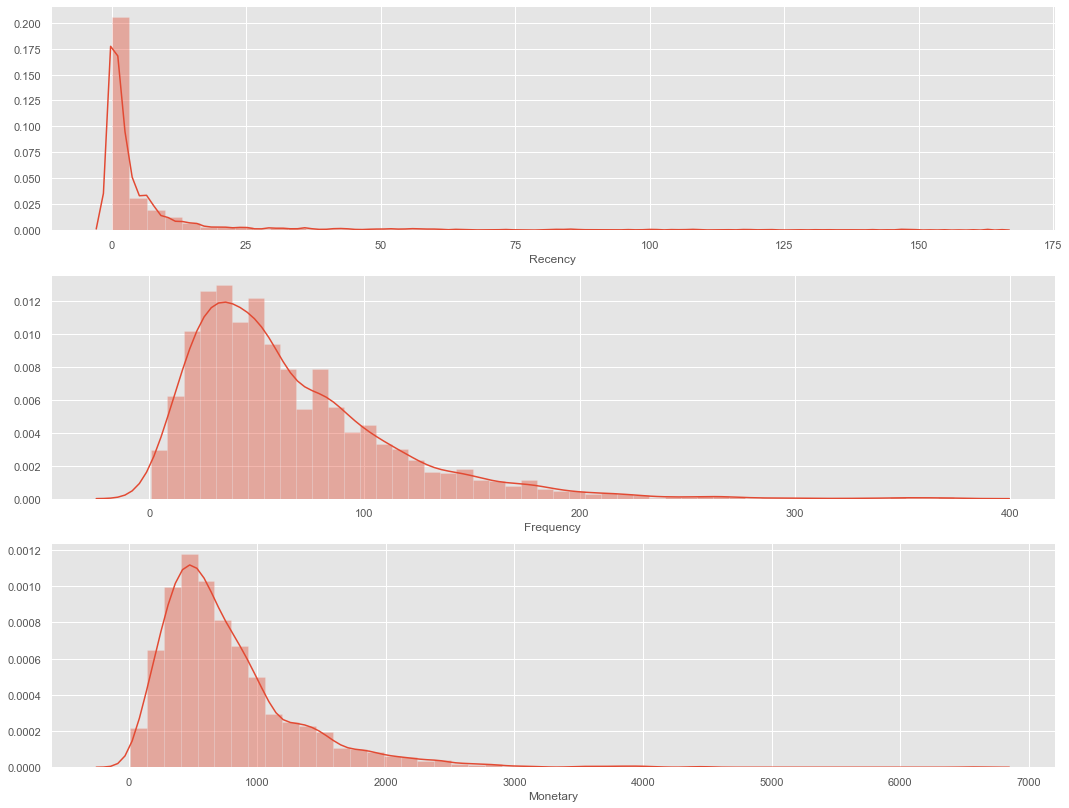

In [24]:
# Distribution of RFM model
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(RFM['Recency'])
plt.subplot(3,1,2); sns.distplot(RFM['Frequency'])
plt.subplot(3,1,3); sns.distplot(RFM['Monetary'])
plt.show()

In [25]:
RFM_ori = RFM.copy()

In [26]:
RFM_ori.head()

,Recency,Frequency,Monetary
customer_number,,,
14,1,56,675.72
45,1,33,585.73
52,2,59,222.18
61,3,37,547.87
63,7,48,293.34


### 6) Applying the log1p transformation to make the data more 'normal'

In [27]:
RFM_log = np.log1p(RFM)

In [28]:
RFM_log.head()

,Recency,Frequency,Monetary
customer_number,,,
14,0.693147,4.043051,6.517258
45,0.693147,3.526361,6.374565
52,1.098612,4.094345,5.407979
61,1.386294,3.637586,6.307862
63,2.079442,3.891820,5.684736


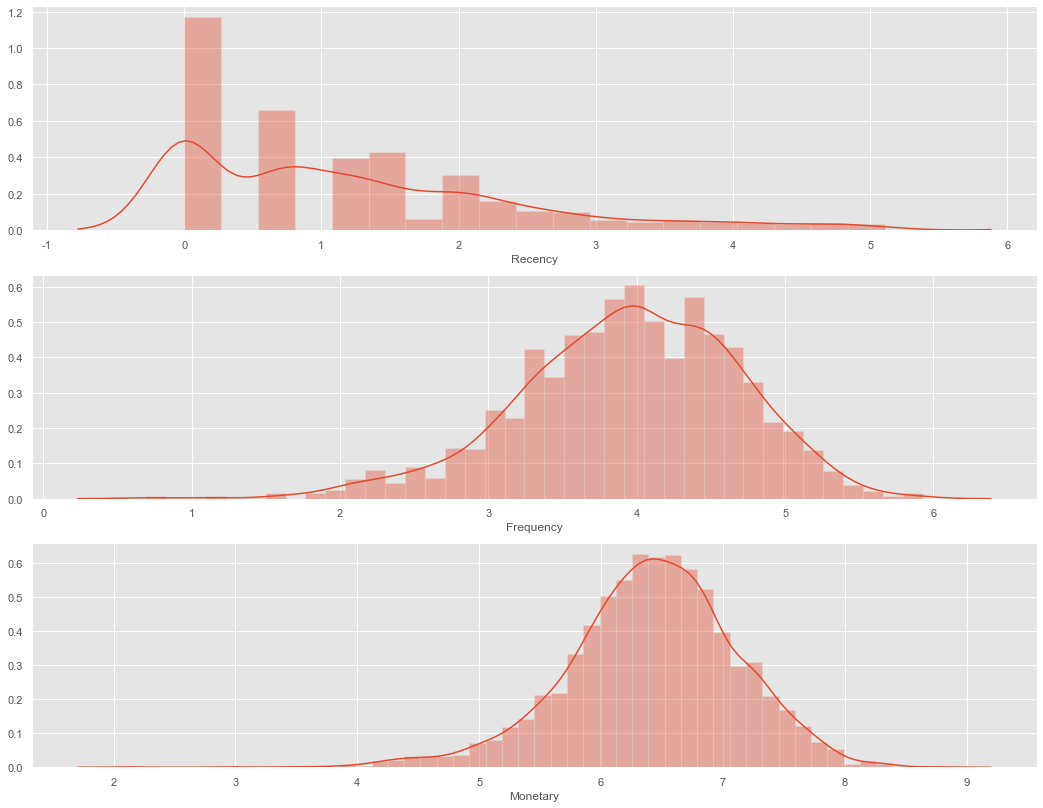

In [29]:
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(RFM_log['Recency'])
plt.subplot(3,1,2); sns.distplot(RFM_log['Frequency'])
plt.subplot(3,1,3); sns.distplot(RFM_log['Monetary'])
plt.show()

## 2. 'spend_habit' dataset
### (customers_sample.csv + baskets_sample.csv)

### 1) Import dataset (customers_sample.csv)

In [30]:
customer = pd.read_csv('customers_sample.csv')

In [31]:
customer = customer.drop(columns=['baskets','average_quantity','average_spend'])

In [32]:
customer.head()

,customer_number,total_quantity,total_spend
0,4749,260,£631.12
1,4757,333,£452.42
2,144,303,£261.16
3,572,346,£638.79
4,669,324,£561.42


In [33]:
customer['total_spend'] = customer['total_spend'
                                  ].str.replace('£','').str.replace(',','').astype(np.float64)


### 2) Import dataset (baskets_sample.csv) 

In [34]:
basket = pd.read_csv('baskets_sample.csv')

In [35]:
basket.head()

,customer_number,purchase_time,basket_quantity,basket_spend,basket_categories
0,11911,2007-03-01 07:06:00,7,£3.09,3
1,4047,2007-03-01 07:13:00,9,£7.99,5
2,3571,2007-03-01 07:27:00,9,£37.06,6
3,4079,2007-03-01 07:34:00,11,£11.91,5
4,6063,2007-03-01 07:36:00,3,£1.45,1


In [36]:
# transform => when creating a new column
basket['basket'] = basket.groupby('customer_number')['customer_number'].transform('count')
basket.head()

,customer_number,purchase_time,basket_quantity,basket_spend,basket_categories,basket
0,11911,2007-03-01 07:06:00,7,£3.09,3,83
1,4047,2007-03-01 07:13:00,9,£7.99,5,178
2,3571,2007-03-01 07:27:00,9,£37.06,6,176
3,4079,2007-03-01 07:34:00,11,£11.91,5,150
4,6063,2007-03-01 07:36:00,3,£1.45,1,347


In [37]:
basket = basket.drop(columns=['purchase_time','basket_quantity',
                     'basket_spend','basket_categories'])

In [38]:
basket = basket.drop_duplicates()

### 3) Merge two dataset to make 'spend_habit' dataset

In [39]:
spend_habit = pd.merge(customer, basket, left_on='customer_number',
                   right_on='customer_number', how='inner') 

In [40]:
spend_habit.head()

,customer_number,total_quantity,total_spend,basket
0,4749,260,631.12,92
1,4757,333,452.42,27
2,144,303,261.16,22
3,572,346,638.79,40
4,669,324,561.42,36


In [41]:
# 1. average quantity (float 64) = total quantity / baskets 
        # => average item count: total basket quantity / new baskets
spend_habit['average_item_count'] = spend_habit['total_quantity'] / spend_habit['basket']

In [42]:
# 2. average spend (object => float64, replace £, ‘,’) = total spend / baskets 
        # => average basket spend: total spend / new baskets
spend_habit['average_basket_spend'] = spend_habit['total_spend'] / spend_habit['basket']

In [43]:
# 3. average spend per item = total spend / total quantity
spend_habit['average_spend_per_item'] = spend_habit['total_spend'] / spend_habit['total_quantity']

In [44]:
spend_habit = spend_habit.round({'average_item_count':2,
                         'average_basket_spend':2,
                        'average_spend_per_item':2})

In [45]:
# drop total spend for RFM model
# drop total quantity for correlation problem
# drop basket for RFM model

spend_habit = spend_habit.drop(columns=['total_spend','total_quantity','basket'])
spend_habit.head()

,customer_number,average_item_count,average_basket_spend,average_spend_per_item
0,4749,2.83,6.86,2.43
1,4757,12.33,16.76,1.36
2,144,13.77,11.87,0.86
3,572,8.65,15.97,1.85
4,669,9.00,15.60,1.73


In [46]:
spend_habit = spend_habit.groupby('customer_number').agg({
    'average_item_count':lambda x:x,
    'average_basket_spend':lambda x:x,
    'average_spend_per_item':lambda x:x
})
spend_habit.head()

,average_item_count,average_basket_spend,average_spend_per_item
customer_number,,,
14,9.48,12.07,1.27
45,19.85,17.75,0.89
52,4.98,3.77,0.76
61,13.49,14.81,1.10
63,5.85,6.11,1.04


In [47]:
spend_habit.describe()

,average_item_count,average_basket_spend,average_spend_per_item
count,3000.000000,3000.000000,3000.000000
mean,11.273407,14.801243,1.394923
std,8.538014,11.161381,0.567371
min,1.200000,1.460000,0.560000
25%,6.117500,8.037500,1.070000
50%,8.730000,11.770000,1.250000
75%,13.390000,17.440000,1.530000
max,90.750000,152.620000,7.920000


### 4) Check the Pearson correlations in 'spend_habit' dataset

In [48]:
# average_item_count - average_basket_item: 0.91
corr = spend_habit.corr()
corr 

,average_item_count,average_basket_spend,average_spend_per_item
average_item_count,1.000000,0.915069,-0.190769
average_basket_spend,0.915069,1.000000,0.137865
average_spend_per_item,-0.190769,0.137865,1.000000


### 5) Check the distribution of each features

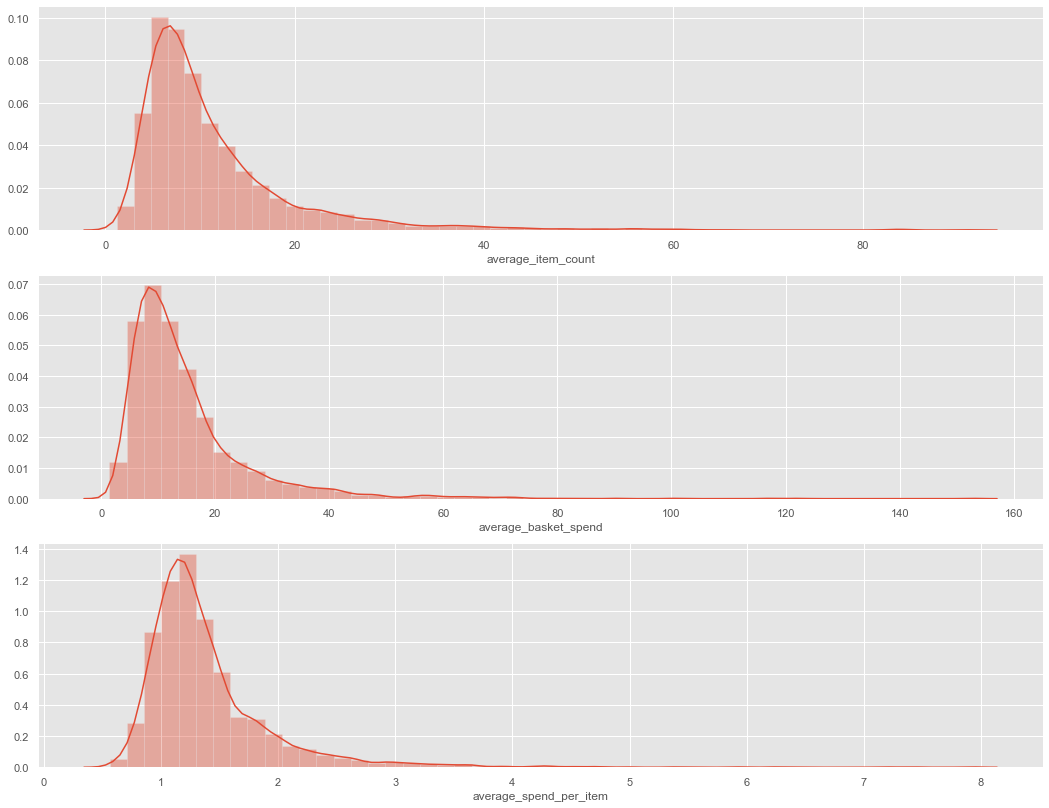

In [49]:
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(spend_habit['average_item_count'])
plt.subplot(3,1,2); sns.distplot(spend_habit['average_basket_spend'])
plt.subplot(3,1,3); sns.distplot(spend_habit['average_spend_per_item'])
plt.show()

In [50]:
spend_habit_ori = spend_habit.copy()

In [51]:
spend_habit_ori.head()

,average_item_count,average_basket_spend,average_spend_per_item
customer_number,,,
14,9.48,12.07,1.27
45,19.85,17.75,0.89
52,4.98,3.77,0.76
61,13.49,14.81,1.10
63,5.85,6.11,1.04


### 6 ) Applying the log1p transformation to make the data more 'normal'

In [52]:
# use same log1p that I applied with above with RFM
spend_habit_log = np.log1p(spend_habit)

In [53]:
spend_habit_log.head()

,average_item_count,average_basket_spend,average_spend_per_item
customer_number,,,
14,2.349469,2.570320,0.819780
45,3.037354,2.931194,0.636577
52,1.788421,1.562346,0.565314
61,2.673459,2.760643,0.741937
63,1.924249,1.961502,0.712950


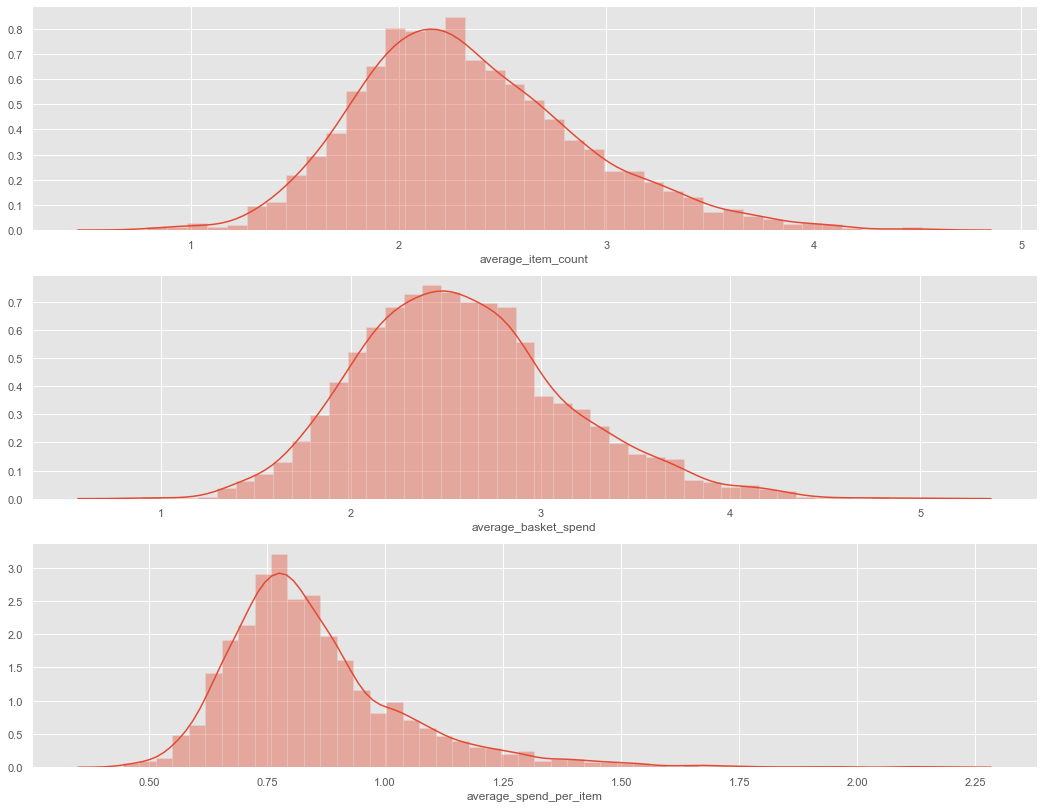

In [54]:
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(spend_habit_log['average_item_count'])
plt.subplot(3,1,2); sns.distplot(spend_habit_log['average_basket_spend'])
plt.subplot(3,1,3); sns.distplot(spend_habit_log['average_spend_per_item'])
plt.show()

In [55]:
spend_habit_log.head()

,average_item_count,average_basket_spend,average_spend_per_item
customer_number,,,
14,2.349469,2.570320,0.819780
45,3.037354,2.931194,0.636577
52,1.788421,1.562346,0.565314
61,2.673459,2.760643,0.741937
63,1.924249,1.961502,0.712950


### 7) Merge RFM_ori and spend_habit_ori to spend_habit_rfm_ori

In [56]:
# rfm_ori + cus_bas_ori
spend_habit_rfm_ori = pd.merge(spend_habit_ori, RFM_ori, left_on='customer_number',
                   right_on='customer_number', how='inner') 
spend_habit_rfm_ori.head()


,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary
customer_number,,,,,,
14,9.48,12.07,1.27,1,56,675.72
45,19.85,17.75,0.89,1,33,585.73
52,4.98,3.77,0.76,2,59,222.18
61,13.49,14.81,1.10,3,37,547.87
63,5.85,6.11,1.04,7,48,293.34


### 8) Merge RFM_log and spend_habit_log to spend_habit_rfm_log

In [57]:
# rfm_log + cus_bas_log
spend_habit_rfm_log = pd.merge(spend_habit_log, RFM_log, left_on='customer_number',
                   right_on='customer_number', how='inner') 
spend_habit_rfm_log.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary
customer_number,,,,,,
14,2.349469,2.570320,0.819780,0.693147,4.043051,6.517258
45,3.037354,2.931194,0.636577,0.693147,3.526361,6.374565
52,1.788421,1.562346,0.565314,1.098612,4.094345,5.407979
61,2.673459,2.760643,0.741937,1.386294,3.637586,6.307862
63,1.924249,1.961502,0.712950,2.079442,3.891820,5.684736


In [58]:
spend_habit_rfm_log.describe()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2.342766,2.590780,0.852214,1.206960,3.945377,6.419434
std,0.544299,0.554939,0.194357,1.209856,0.739076,0.701663
min,0.788457,0.900161,0.444686,0.000000,0.693147,2.113843
25%,1.962556,2.201382,0.727549,0.000000,3.496508,6.009108
50%,2.275214,2.547098,0.810930,1.098612,3.988984,6.442811
75%,2.666534,2.914522,0.928219,1.945910,4.465908,6.865552
max,4.519067,5.034482,2.188296,5.105945,5.926926,8.793256


### 9) Check the Pearson correlations in 'spend_habit_rfm_log' dataset

In [59]:
corr = spend_habit_rfm_log.corr()
'''
average_item_count: average_basket_spend 0.86
Frequency: Monetary 0.66

Recency: Frequency -0.54 ?? new corrleation after log1p transform 
'''
corr

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary
average_item_count,1.000000,0.865978,-0.277884,0.163094,-0.481542,0.216272
average_basket_spend,0.865978,1.000000,0.235813,0.176682,-0.494521,0.318651
average_spend_per_item,-0.277884,0.235813,1.000000,0.019780,-0.017810,0.185737
Recency,0.163094,0.176682,0.019780,1.000000,-0.542952,-0.442638
Frequency,-0.481542,-0.494521,-0.017810,-0.542952,1.000000,0.665252
Monetary,0.216272,0.318651,0.185737,-0.442638,0.665252,1.000000


## 3. 'item_spend' dataset
### (category_spends_sample.csv + lineitems_sample.csv)

### 1) Import dataset (category_spends_sample.csv)

In [60]:
spend = pd.read_csv('category_spends_sample.csv')

In [61]:
spend['practical_items'] = spend['practical_items'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['fruit_veg'] = spend['fruit_veg'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['seasonal_gifting'] = spend['seasonal_gifting'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['discount_bakery'] = spend['discount_bakery'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)

spend['drinks'] = spend['drinks'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['deli'] = spend['deli'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['world_foods'] = spend['world_foods'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['lottery'] = spend['lottery'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['cashpoint'] = spend['cashpoint'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)

spend['dairy'] = spend['dairy'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['confectionary'] = spend['confectionary'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['grocery_food'] = spend['grocery_food'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['grocery_health_pets'] = spend['grocery_health_pets'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['bakery'] = spend['bakery'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['newspapers_magazines'] = spend['newspapers_magazines'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['prepared_meals'] = spend['prepared_meals'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['soft_drinks'] = spend['soft_drinks'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['frozen'] = spend['frozen'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['meat'] = spend['meat'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)
spend['tobacco'] = spend['tobacco'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)

In [62]:
spend.head()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,prepared_meals,soft_drinks,...,meat,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items
0,11387,64.58,35.91,107.78,27.08,29.59,0.0,54.83,6.35,22.83,...,28.62,162.1,28.02,28.12,28.54,2.0,15.0,7.48,0.0,0.84
1,8171,16.89,37.24,28.84,33.43,66.40,0.0,22.06,12.09,2.34,...,26.44,0.0,8.42,2.65,3.76,0.0,0.0,9.99,0.0,0.00
2,1060,87.30,82.98,49.88,20.57,37.04,0.0,9.85,57.98,31.12,...,54.65,0.0,0.00,2.60,0.00,18.0,20.0,106.46,0.0,0.00
3,3728,84.05,186.56,175.50,119.84,111.08,0.0,13.05,25.54,124.42,...,0.95,127.7,0.00,0.00,0.00,4.0,0.0,0.00,0.0,4.50
4,14621,35.16,121.31,79.23,29.03,37.17,0.0,40.06,0.00,4.68,...,36.24,0.0,2.55,99.16,0.00,0.0,0.0,3.40,0.0,0.00


In [63]:
spend.describe()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,prepared_meals,soft_drinks,...,meat,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0,3000.000000,3000.00000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8095.724333,69.456163,71.302683,57.347793,60.007530,60.909867,0.0,16.653390,35.48057,23.303350,...,54.740687,92.547613,62.242217,13.736440,8.554260,14.165603,45.330583,6.126987,1.814837,2.016220
std,4686.259488,70.499654,57.966265,55.959350,57.682533,69.805023,0.0,26.377091,41.24047,35.695592,...,67.802126,201.703812,121.500365,25.486136,14.757745,48.469754,123.584361,13.104271,9.450367,4.322232
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-74.000000,0.000000,0.000000,0.000000,0.000000
25%,4044.750000,22.695000,31.390000,21.070000,21.087500,18.145000,0.0,1.500000,8.70000,3.750000,...,12.640000,0.000000,0.000000,0.000000,0.890000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8218.500000,50.935000,56.875000,42.290000,44.030000,39.075000,0.0,7.345000,23.09500,11.685000,...,32.930000,2.030000,12.830000,3.495000,3.760000,0.000000,0.000000,1.990000,0.000000,0.000000
75%,12115.500000,93.405000,95.327500,75.125000,80.922500,77.250000,0.0,19.687500,47.33000,28.782500,...,72.380000,81.030000,65.150000,15.770000,10.647500,6.000000,30.000000,6.720000,0.000000,2.510000
max,16316.000000,1262.970000,708.040000,614.370000,1017.070000,884.450000,0.0,351.730000,454.29000,529.650000,...,713.280000,2488.940000,1005.330000,316.190000,321.490000,946.000000,2137.010000,229.440000,173.060000,65.060000


### 2) Import dataset (lineitems_sample.csv)

In [64]:
item = pd.read_csv('lineitems_sample.csv')
item.head()

,customer_number,purchase_time,product_id,category,quantity,spend
0,14577,2007-03-10 11:58:00,722653,GROCERY_FOOD,1,£1.39
1,7210,2007-03-22 10:53:00,696136,GROCERY_HEALTH_PETS,1,£4.25
2,3145,2007-03-26 11:17:00,139543,GROCERY_HEALTH_PETS,1,£0.50
3,2649,2007-03-12 16:05:00,34890,BAKERY,1,£0.57
4,859,2007-03-10 09:53:00,613984,BAKERY,1,£1.59


In [65]:
item.dtypes

customer_number     int64
purchase_time      object
product_id          int64
category           object
quantity            int64
spend              object
dtype: object

In [66]:
item['spend'] = item['spend'
                          ].str.replace('£','').str.replace(',','').astype(np.float64)

In [67]:
category = item.groupby(by=['customer_number','category']
                       ).agg({'spend':[np.sum]}).unstack()
category.head()

spend                                                         \
                   sum                                                          
category        BAKERY CASHPOINT CONFECTIONARY   DAIRY   DELI DISCOUNT_BAKERY   
customer_number                                                                 
14               18.09       NaN         23.22  172.58    NaN            1.25   
45               18.00       NaN        106.54  142.16   2.00             NaN   
52                2.45      10.0          3.29    5.19  49.07             NaN   
61               32.75       NaN         46.39   55.29  19.88             NaN   
63               33.35       NaN         73.07   42.11  32.14             NaN   

                                                                           \
                                                                            
category         DRINKS FROZEN FRUIT_VEG GROCERY_FOOD GROCERY_HEALTH_PETS   
customer_number                                                             
14               113.45  25.29     11.10        56.05               11.28   
45                  NaN   7.05     30.21        83.42               24.31   
52                  NaN   1.78     53.29         1.08               12.11   
61                20.65  18.63     70.18        56.18               45.71   
63                  NaN  14.53     22.01        13.54               25.08   

                                                                      \
                                                                       
category        LOTTERY    MEAT NEWSPAPERS_MAGAZINES PRACTICAL_ITEMS   
customer_number                                                        
14                  NaN  182.37                 6.40             NaN   
45                  NaN   60.31                17.49             NaN   
52                  1.0    9.74                 3.12             NaN   
61                  6.0  121.38                 5.55            2.87   
63                  3.0    3.46                 2.00             NaN   

                                                                     \
                                                                      
category        PREPARED_MEALS SEASONAL_GIFTING SOFT_DRINKS TOBACCO   
customer_number                                                       
14                       23.36             5.07        5.31     NaN   
45                       56.51              NaN       29.65     NaN   
52                        2.78            23.20        8.98     NaN   
61                       12.12             3.04       14.87     NaN   
63                       13.38              NaN        1.67     NaN   

                             
                             
category        WORLD_FOODS  
customer_number              
14                    20.90  
45                     8.08  
52                    35.10  
61                    16.38  
63                    14.00

In [68]:
category.isna().sum()

            category            
spend  sum  BAKERY                    37
            CASHPOINT               1794
            CONFECTIONARY             18
            DAIRY                     13
            DELI                    1050
            DISCOUNT_BAKERY         2664
            DRINKS                   915
            FROZEN                   152
            FRUIT_VEG                 19
            GROCERY_FOOD              18
            GROCERY_HEALTH_PETS       49
            LOTTERY                 1836
            MEAT                     177
            NEWSPAPERS_MAGAZINES     463
            PRACTICAL_ITEMS         1810
            PREPARED_MEALS           142
            SEASONAL_GIFTING        1096
            SOFT_DRINKS              224
            TOBACCO                 1443
            WORLD_FOODS              593
dtype: int64

In [69]:
category = category.fillna(0)
category.head()

spend                                                         \
                   sum                                                          
category        BAKERY CASHPOINT CONFECTIONARY   DAIRY   DELI DISCOUNT_BAKERY   
customer_number                                                                 
14               18.09       0.0         23.22  172.58   0.00            1.25   
45               18.00       0.0        106.54  142.16   2.00            0.00   
52                2.45      10.0          3.29    5.19  49.07            0.00   
61               32.75       0.0         46.39   55.29  19.88            0.00   
63               33.35       0.0         73.07   42.11  32.14            0.00   

                                                                           \
                                                                            
category         DRINKS FROZEN FRUIT_VEG GROCERY_FOOD GROCERY_HEALTH_PETS   
customer_number                                                             
14               113.45  25.29     11.10        56.05               11.28   
45                 0.00   7.05     30.21        83.42               24.31   
52                 0.00   1.78     53.29         1.08               12.11   
61                20.65  18.63     70.18        56.18               45.71   
63                 0.00  14.53     22.01        13.54               25.08   

                                                                      \
                                                                       
category        LOTTERY    MEAT NEWSPAPERS_MAGAZINES PRACTICAL_ITEMS   
customer_number                                                        
14                  0.0  182.37                 6.40            0.00   
45                  0.0   60.31                17.49            0.00   
52                  1.0    9.74                 3.12            0.00   
61                  6.0  121.38                 5.55            2.87   
63                  3.0    3.46                 2.00            0.00   

                                                                     \
                                                                      
category        PREPARED_MEALS SEASONAL_GIFTING SOFT_DRINKS TOBACCO   
customer_number                                                       
14                       23.36             5.07        5.31     0.0   
45                       56.51             0.00       29.65     0.0   
52                        2.78            23.20        8.98     0.0   
61                       12.12             3.04       14.87     0.0   
63                       13.38             0.00        1.67     0.0   

                             
                             
category        WORLD_FOODS  
customer_number              
14                    20.90  
45                     8.08  
52                    35.10  
61                    16.38  
63                    14.00

In [70]:
category = category.rename_axis().reset_index()
category.head()

customer_number  spend                                         \
                            sum                                          
category                 BAKERY CASHPOINT CONFECTIONARY   DAIRY   DELI   
0                     14  18.09       0.0         23.22  172.58   0.00   
1                     45  18.00       0.0        106.54  142.16   2.00   
2                     52   2.45      10.0          3.29    5.19  49.07   
3                     61  32.75       0.0         46.39   55.29  19.88   
4                     63  33.35       0.0         73.07   42.11  32.14   

                                                   ...                      \
                                                   ...                       
category DISCOUNT_BAKERY  DRINKS FROZEN FRUIT_VEG  ... GROCERY_HEALTH_PETS   
0                   1.25  113.45  25.29     11.10  ...               11.28   
1                   0.00    0.00   7.05     30.21  ...               24.31   
2                   0.00    0.00   1.78     53.29  ...               12.11   
3                   0.00   20.65  18.63     70.18  ...               45.71   
4                   0.00    0.00  14.53     22.01  ...               25.08   

                                                                              \
                                                                               
category LOTTERY    MEAT NEWSPAPERS_MAGAZINES PRACTICAL_ITEMS PREPARED_MEALS   
0            0.0  182.37                 6.40            0.00          23.36   
1            0.0   60.31                17.49            0.00          56.51   
2            1.0    9.74                 3.12            0.00           2.78   
3            6.0  121.38                 5.55            2.87          12.12   
4            3.0    3.46                 2.00            0.00          13.38   

                                                           
                                                           
category SEASONAL_GIFTING SOFT_DRINKS TOBACCO WORLD_FOODS  
0                    5.07        5.31     0.0       20.90  
1                    0.00       29.65     0.0        8.08  
2                   23.20        8.98     0.0       35.10  
3                    3.04       14.87     0.0       16.38  
4                    0.00        1.67     0.0       14.00  

[5 rows x 21 columns]

In [71]:
category[category['customer_number']==14]

customer_number  spend                                       \
                            sum                                        
category                 BAKERY CASHPOINT CONFECTIONARY   DAIRY DELI   
0                     14  18.09       0.0         23.22  172.58  0.0   

                                                   ...                      \
                                                   ...                       
category DISCOUNT_BAKERY  DRINKS FROZEN FRUIT_VEG  ... GROCERY_HEALTH_PETS   
0                   1.25  113.45  25.29      11.1  ...               11.28   

                                                                              \
                                                                               
category LOTTERY    MEAT NEWSPAPERS_MAGAZINES PRACTICAL_ITEMS PREPARED_MEALS   
0            0.0  182.37                  6.4             0.0          23.36   

                                                           
                                                           
category SEASONAL_GIFTING SOFT_DRINKS TOBACCO WORLD_FOODS  
0                    5.07        5.31     0.0        20.9  

[1 rows x 21 columns]

In [72]:
# compare with spend dataset
spend[spend['customer_number']==14]

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,prepared_meals,soft_drinks,...,meat,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items
427,14,11.1,172.58,23.22,56.05,11.28,0.0,6.4,23.36,5.31,...,182.37,0.0,113.45,0.0,20.9,0.0,0.0,5.07,1.25,0.0


### 3) Replacing 'bakery'feature in spend from category

In [73]:
# drop bakery in spend
spend = spend.drop(columns='bakery')

In [74]:
category_bakery = category.iloc[:, [0,1]]

In [75]:
category_bakery.head()

,customer_number,spend
,,sum
category,,BAKERY
0,14,18.09
1,45,18.00
2,52,2.45
3,61,32.75
4,63,33.35


In [76]:
category_bakery.columns = ['customer_number', 'bakery'] 

In [77]:
category_bakery.head()

,customer_number,bakery
0,14,18.09
1,45,18.00
2,52,2.45
3,61,32.75
4,63,33.35


In [78]:
# spend with bakery feature
spend = pd.merge(spend, category_bakery, left_on='customer_number',
                   right_on='customer_number', how='inner') 
spend.head()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,newspapers_magazines,prepared_meals,soft_drinks,frozen,...,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items,bakery
0,11387,64.58,35.91,107.78,27.08,29.59,54.83,6.35,22.83,21.51,...,162.1,28.02,28.12,28.54,2.0,15.0,7.48,0.0,0.84,26.58
1,8171,16.89,37.24,28.84,33.43,66.40,22.06,12.09,2.34,78.74,...,0.0,8.42,2.65,3.76,0.0,0.0,9.99,0.0,0.00,20.02
2,1060,87.30,82.98,49.88,20.57,37.04,9.85,57.98,31.12,14.53,...,0.0,0.00,2.60,0.00,18.0,20.0,106.46,0.0,0.00,75.72
3,3728,84.05,186.56,175.50,119.84,111.08,13.05,25.54,124.42,15.24,...,127.7,0.00,0.00,0.00,4.0,0.0,0.00,0.0,4.50,111.67
4,14621,35.16,121.31,79.23,29.03,37.17,40.06,0.00,4.68,3.33,...,0.0,2.55,99.16,0.00,0.0,0.0,3.40,0.0,0.00,33.13


In [79]:
spend[spend['customer_number']==14]

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,newspapers_magazines,prepared_meals,soft_drinks,frozen,...,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items,bakery
427,14,11.1,172.58,23.22,56.05,11.28,6.4,23.36,5.31,25.29,...,0.0,113.45,0.0,20.9,0.0,0.0,5.07,1.25,0.0,18.09


### 4) Check the Pearson correlations in 'spend' dataset

In [80]:
corr = spend.corr()

In [81]:
corr

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,newspapers_magazines,prepared_meals,soft_drinks,frozen,...,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items,bakery
customer_number,1.000000,-0.081879,-0.083583,-0.094811,-0.044161,-0.073822,-0.098787,-0.115383,-0.053060,-0.107980,...,0.076524,-0.013866,0.001120,-0.044833,0.038263,0.015227,-0.016623,-0.016584,-0.053567,-0.094028
fruit_veg,-0.081879,1.000000,0.629616,0.465602,0.640928,0.490674,0.136383,0.449565,0.259851,0.420811,...,-0.017992,0.108806,0.225524,0.206913,-0.018643,-0.049082,0.206127,0.046758,0.272480,0.447188
dairy,-0.083583,0.629616,1.000000,0.610100,0.651492,0.557530,0.219894,0.509525,0.404795,0.531251,...,0.090944,0.070143,0.224616,0.243247,0.036770,0.020423,0.234176,0.000576,0.277045,0.608368
confectionary,-0.094811,0.465602,0.610100,1.000000,0.574594,0.577793,0.211944,0.471222,0.537825,0.574330,...,0.060835,0.013506,0.206669,0.246258,0.014559,0.038862,0.277407,0.057857,0.274943,0.542105
grocery_food,-0.044161,0.640928,0.651492,0.574594,1.000000,0.581256,0.130919,0.481753,0.365991,0.569792,...,0.062182,0.092420,0.212570,0.180413,0.011811,-0.015510,0.195960,0.043531,0.260195,0.522479
grocery_health_pets,-0.073822,0.490674,0.557530,0.577793,0.581256,1.000000,0.149942,0.454817,0.423348,0.529290,...,0.111003,0.105609,0.202879,0.164953,0.000656,-0.001513,0.275854,0.052803,0.328277,0.439587
newspapers_magazines,-0.098787,0.136383,0.219894,0.211944,0.130919,0.149942,1.000000,0.116249,0.166075,0.145995,...,0.168561,0.055905,0.106366,0.210119,0.183646,0.134558,0.130389,0.034357,0.134072,0.263523
prepared_meals,-0.115383,0.449565,0.509525,0.471222,0.481753,0.454817,0.116249,1.000000,0.347851,0.452483,...,0.075849,0.087040,0.138281,0.216741,0.007068,0.027041,0.178150,-0.004831,0.203791,0.443646
soft_drinks,-0.053060,0.259851,0.404795,0.537825,0.365991,0.423348,0.166075,0.347851,1.000000,0.390323,...,0.143746,0.153551,0.158215,0.130028,0.063034,0.095548,0.196315,0.053548,0.155121,0.349372
frozen,-0.107980,0.420811,0.531251,0.574330,0.569792,0.529290,0.145995,0.452483,0.390323,1.000000,...,0.036792,0.054573,0.185054,0.196964,-0.016447,0.005054,0.192881,0.108158,0.230981,0.448760



    Correlation over 0.50
    
    fruit veg: dairy 0.62 / grocery_food 0.64 / meat 0.55
    dairy:     fruit veg 0.62 / confectionary 0.61 / grocery_food 0.65
               grocery_health_pets 0.55 / prepared_meals 0.5 / frozen 0.53
    confect:   dairy 0.61 / grocery_food 0.57 / grocery_health_pets 0.57
               soft_drinks 0.53 / frozen 0.52
    grocery:   fruit veg 0.64 / dairy 0.65 / confectionary 0.57
               grocery_health_pets 0.57 / soft_drinks 0.6 / frozen 0.55
               meat 0.55
    gro_pets:  dairy 0.55 / confectionary 0.57 / grocery_food 0.57
	           frozen 0.52
    prepared_meals: dairy 0.5
    soft drinks:    confectionary 0.53
    frozen:         dairy / confectionary / grocery_food / gro_pets
    meat:           fruit veg / grocery_food
    bakery:         dariy / confectionary / grocery_food


In [82]:
spend.head()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,newspapers_magazines,prepared_meals,soft_drinks,frozen,...,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items,bakery
0,11387,64.58,35.91,107.78,27.08,29.59,54.83,6.35,22.83,21.51,...,162.1,28.02,28.12,28.54,2.0,15.0,7.48,0.0,0.84,26.58
1,8171,16.89,37.24,28.84,33.43,66.40,22.06,12.09,2.34,78.74,...,0.0,8.42,2.65,3.76,0.0,0.0,9.99,0.0,0.00,20.02
2,1060,87.30,82.98,49.88,20.57,37.04,9.85,57.98,31.12,14.53,...,0.0,0.00,2.60,0.00,18.0,20.0,106.46,0.0,0.00,75.72
3,3728,84.05,186.56,175.50,119.84,111.08,13.05,25.54,124.42,15.24,...,127.7,0.00,0.00,0.00,4.0,0.0,0.00,0.0,4.50,111.67
4,14621,35.16,121.31,79.23,29.03,37.17,40.06,0.00,4.68,3.33,...,0.0,2.55,99.16,0.00,0.0,0.0,3.40,0.0,0.00,33.13


In [83]:
spend.describe()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,newspapers_magazines,prepared_meals,soft_drinks,frozen,...,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items,bakery
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8095.724333,69.456163,71.302683,57.347793,60.007530,60.909867,16.653390,35.48057,23.303350,35.466020,...,92.547613,62.242217,13.736440,8.554260,14.165603,45.330583,6.126987,1.814837,2.016220,38.210123
std,4686.259488,70.499654,57.966265,55.959350,57.682533,69.805023,26.377091,41.24047,35.695592,41.477609,...,201.703812,121.500365,25.486136,14.757745,48.469754,123.584361,13.104271,9.450367,4.322232,36.496115
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-74.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4044.750000,22.695000,31.390000,21.070000,21.087500,18.145000,1.500000,8.70000,3.750000,8.777500,...,0.000000,0.000000,0.000000,0.890000,0.000000,0.000000,0.000000,0.000000,0.000000,14.635000
50%,8218.500000,50.935000,56.875000,42.290000,44.030000,39.075000,7.345000,23.09500,11.685000,22.275000,...,2.030000,12.830000,3.495000,3.760000,0.000000,0.000000,1.990000,0.000000,0.000000,29.270000
75%,12115.500000,93.405000,95.327500,75.125000,80.922500,77.250000,19.687500,47.33000,28.782500,47.237500,...,81.030000,65.150000,15.770000,10.647500,6.000000,30.000000,6.720000,0.000000,2.510000,50.050000
max,16316.000000,1262.970000,708.040000,614.370000,1017.070000,884.450000,351.730000,454.29000,529.650000,385.800000,...,2488.940000,1005.330000,316.190000,321.490000,946.000000,2137.010000,229.440000,173.060000,65.060000,444.370000


### 5) Dropping features that 0 value until 25% (= deleting 8 feature)

In [84]:
# droping features that 0 value until 25% (= deleting 8 feature)
spend_12 = spend.drop(columns=['tobacco','drinks','deli','lottery','cashpoint',
                              'seasonal_gifting', 'discount_bakery',
                             'practical_items'])
spend_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 13 columns):
customer_number         3000 non-null int64
fruit_veg               3000 non-null float64
dairy                   3000 non-null float64
confectionary           3000 non-null float64
grocery_food            3000 non-null float64
grocery_health_pets     3000 non-null float64
newspapers_magazines    3000 non-null float64
prepared_meals          3000 non-null float64
soft_drinks             3000 non-null float64
frozen                  3000 non-null float64
meat                    3000 non-null float64
world_foods             3000 non-null float64
bakery                  3000 non-null float64
dtypes: float64(12), int64(1)
memory usage: 328.1 KB


In [85]:
spend_12.describe()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,newspapers_magazines,prepared_meals,soft_drinks,frozen,meat,world_foods,bakery
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8095.724333,69.456163,71.302683,57.347793,60.007530,60.909867,16.653390,35.48057,23.303350,35.466020,54.740687,8.554260,38.210123
std,4686.259488,70.499654,57.966265,55.959350,57.682533,69.805023,26.377091,41.24047,35.695592,41.477609,67.802126,14.757745,36.496115
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4044.750000,22.695000,31.390000,21.070000,21.087500,18.145000,1.500000,8.70000,3.750000,8.777500,12.640000,0.890000,14.635000
50%,8218.500000,50.935000,56.875000,42.290000,44.030000,39.075000,7.345000,23.09500,11.685000,22.275000,32.930000,3.760000,29.270000
75%,12115.500000,93.405000,95.327500,75.125000,80.922500,77.250000,19.687500,47.33000,28.782500,47.237500,72.380000,10.647500,50.050000
max,16316.000000,1262.970000,708.040000,614.370000,1017.070000,884.450000,351.730000,454.29000,529.650000,385.800000,713.280000,321.490000,444.370000


In [86]:
for i in spend_12:
    print(i,':',spend_12[i].sum())

customer_number : 24287173
fruit_veg : 208368.49
dairy : 213908.05
confectionary : 172043.38
grocery_food : 180022.59
grocery_health_pets : 182729.59999999998
newspapers_magazines : 49960.17
prepared_meals : 106441.70999999999
soft_drinks : 69910.04999999999
frozen : 106398.06
meat : 164222.06
world_foods : 25662.78
bakery : 114630.37


### 6) Dropping features that total spend is lower than 100,000 (= deleting 3 feature)

In [87]:
# drop features that total spend is lower than 100,000 (= deleting 3 feature)
spend_9 = spend_12.drop(columns=['newspapers_magazines','soft_drinks',
                             'world_foods'])

In [88]:
spend_9.head()

,customer_number,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
0,11387,64.58,35.91,107.78,27.08,29.59,6.35,21.51,28.62,26.58
1,8171,16.89,37.24,28.84,33.43,66.40,12.09,78.74,26.44,20.02
2,1060,87.30,82.98,49.88,20.57,37.04,57.98,14.53,54.65,75.72
3,3728,84.05,186.56,175.50,119.84,111.08,25.54,15.24,0.95,111.67
4,14621,35.16,121.31,79.23,29.03,37.17,0.00,3.33,36.24,33.13


### 7) Making a new dataset 'item_spend' dataset 

In [89]:
item_spend = spend_9.groupby('customer_number').agg({
    'fruit_veg':lambda x:x,
    'dairy':lambda x:x,
    'confectionary':lambda x:x,
    'grocery_food':lambda x:x,
    'grocery_health_pets':lambda x:x,
    'prepared_meals':lambda x:x,
    'frozen':lambda x:x,
    'meat':lambda x:x,
    'bakery':lambda x:x
})
item_spend.head()

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,
14,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
45,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
52,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
61,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
63,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


In [90]:
item_spend.describe()

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000
mean,69.456163,71.302683,57.347793,60.007530,60.909867,35.48057,35.466020,54.740687,38.210123
std,70.499654,57.966265,55.959350,57.682533,69.805023,41.24047,41.477609,67.802126,36.496115
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,22.695000,31.390000,21.070000,21.087500,18.145000,8.70000,8.777500,12.640000,14.635000
50%,50.935000,56.875000,42.290000,44.030000,39.075000,23.09500,22.275000,32.930000,29.270000
75%,93.405000,95.327500,75.125000,80.922500,77.250000,47.33000,47.237500,72.380000,50.050000
max,1262.970000,708.040000,614.370000,1017.070000,884.450000,454.29000,385.800000,713.280000,444.370000


### 8) Check the Pearson correlations in 'item_spend' dataset

In [91]:
corr = item_spend.corr()
corr

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
fruit_veg,1.000000,0.629616,0.465602,0.640928,0.490674,0.449565,0.420811,0.550687,0.447188
dairy,0.629616,1.000000,0.610100,0.651492,0.557530,0.509525,0.531251,0.492942,0.608368
confectionary,0.465602,0.610100,1.000000,0.574594,0.577793,0.471222,0.574330,0.440183,0.542105
grocery_food,0.640928,0.651492,0.574594,1.000000,0.581256,0.481753,0.569792,0.556404,0.522479
grocery_health_pets,0.490674,0.557530,0.577793,0.581256,1.000000,0.454817,0.529290,0.450822,0.439587
prepared_meals,0.449565,0.509525,0.471222,0.481753,0.454817,1.000000,0.452483,0.486497,0.443646
frozen,0.420811,0.531251,0.574330,0.569792,0.529290,0.452483,1.000000,0.457836,0.448760
meat,0.550687,0.492942,0.440183,0.556404,0.450822,0.486497,0.457836,1.000000,0.439181
bakery,0.447188,0.608368,0.542105,0.522479,0.439587,0.443646,0.448760,0.439181,1.000000


### 9) Check the distribution of each features

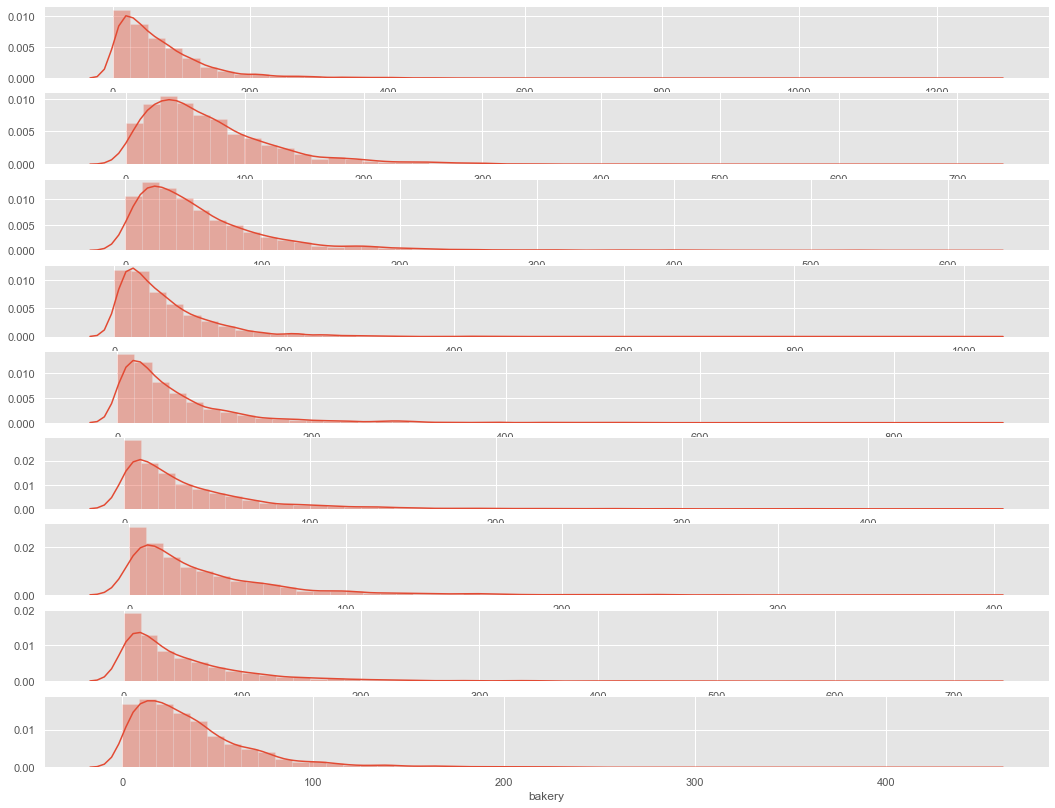

In [92]:
plt.figure(figsize=(18,14))
plt.subplot(9,1,1); sns.distplot(item_spend['fruit_veg'])
plt.subplot(9,1,2); sns.distplot(item_spend['dairy'])
plt.subplot(9,1,3); sns.distplot(item_spend['confectionary'])
plt.subplot(9,1,4); sns.distplot(item_spend['grocery_food'])
plt.subplot(9,1,5); sns.distplot(item_spend['grocery_health_pets'])
plt.subplot(9,1,6); sns.distplot(item_spend['prepared_meals'])
plt.subplot(9,1,7); sns.distplot(item_spend['frozen'])
plt.subplot(9,1,8); sns.distplot(item_spend['meat'])
plt.subplot(9,1,9); sns.distplot(item_spend['bakery'])
plt.show()

In [93]:
item_spend_ori = item_spend.copy()
item_spend_ori.head()

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,
14,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
45,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
52,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
61,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
63,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


### 10) Applying the log1p transformation to make the data more 'normal' 

In [94]:
item_spend_log = np.log1p(item_spend)
item_spend_log.head()

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,
14,2.493205,5.156639,3.187179,4.043928,2.507972,3.192942,3.269189,5.211506,2.949165
45,3.440739,4.963963,4.677863,4.435804,3.231200,4.051959,2.085672,4.115943,2.944439
52,3.994340,1.822935,1.456287,0.732368,2.573375,1.329724,1.022451,2.373975,1.238374
61,4.265212,4.030517,3.858411,4.046204,3.843958,2.574138,2.977059,4.807131,3.518980
63,3.135929,3.763755,4.305011,2.676903,3.261169,2.665838,2.742774,1.495149,3.536602


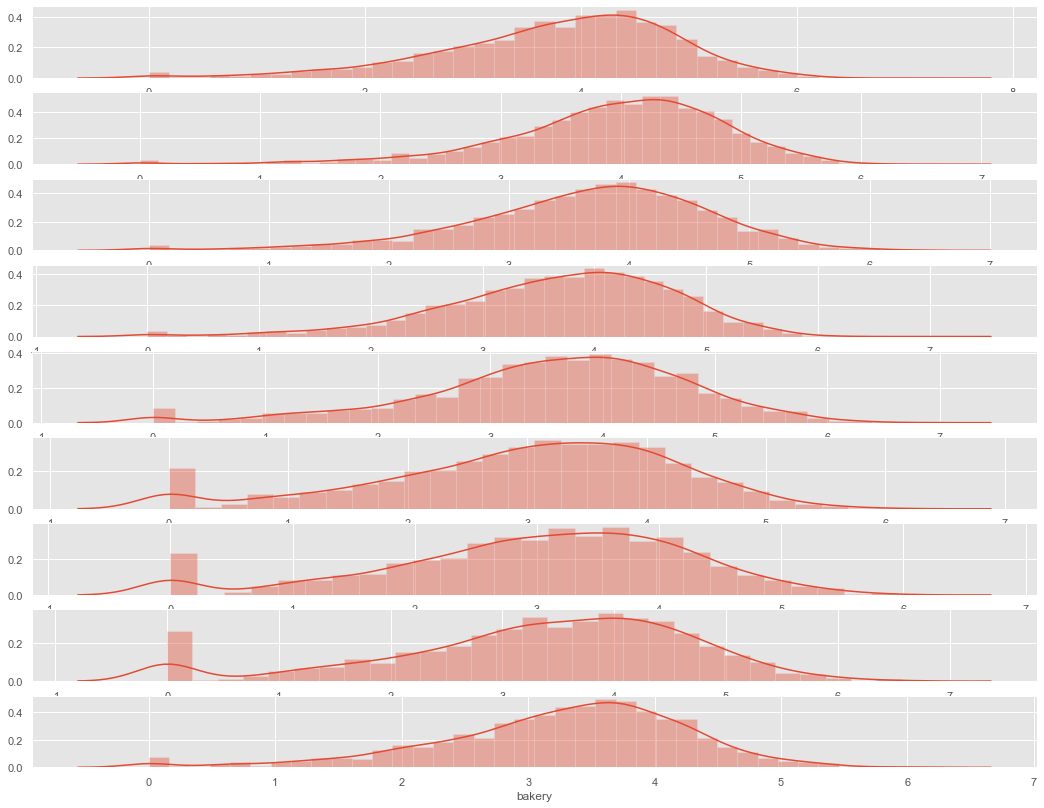

In [95]:
plt.figure(figsize=(18,14))
plt.subplot(9,1,1); sns.distplot(item_spend_log['fruit_veg'])
plt.subplot(9,1,2); sns.distplot(item_spend_log['dairy'])
plt.subplot(9,1,3); sns.distplot(item_spend_log['confectionary'])
plt.subplot(9,1,4); sns.distplot(item_spend_log['grocery_food'])
plt.subplot(9,1,5); sns.distplot(item_spend_log['grocery_health_pets'])
plt.subplot(9,1,6); sns.distplot(item_spend_log['prepared_meals'])
plt.subplot(9,1,7); sns.distplot(item_spend_log['frozen'])
plt.subplot(9,1,8); sns.distplot(item_spend_log['meat'])
plt.subplot(9,1,9); sns.distplot(item_spend_log['bakery'])
plt.show()

### 10) Merge spend_habit_rfm_ori and item_spend_ori to df_ori

In [96]:
# cus_bas_rfm_ori + item_spend_ori
df_ori = pd.merge(spend_habit_rfm_ori, item_spend_ori, left_on='customer_number',
                   right_on='customer_number', how='inner') 
df_ori.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,,,,,,,
14,9.48,12.07,1.27,1,56,675.72,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
45,19.85,17.75,0.89,1,33,585.73,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
52,4.98,3.77,0.76,2,59,222.18,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
61,13.49,14.81,1.10,3,37,547.87,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
63,5.85,6.11,1.04,7,48,293.34,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


In [97]:
corr = df_ori.corr()
corr

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
average_item_count,1.000000,0.915069,-0.190769,0.091122,-0.372985,0.228918,0.383803,0.305094,0.358659,0.434644,0.406408,0.299873,0.350354,0.334297,0.205458
average_basket_spend,0.915069,1.000000,0.137865,0.096117,-0.368888,0.315238,0.333912,0.245811,0.289181,0.378350,0.387599,0.288395,0.306310,0.340579,0.143935
average_spend_per_item,-0.190769,0.137865,1.000000,0.007386,-0.007982,0.183322,-0.165218,-0.185242,-0.194968,-0.170010,-0.093308,-0.078288,-0.134664,-0.054551,-0.177941
Recency,0.091122,0.096117,0.007386,1.000000,-0.269369,-0.245395,-0.169856,-0.204230,-0.156000,-0.165360,-0.136923,-0.134440,-0.131577,-0.129191,-0.189143
Frequency,-0.372985,-0.368888,-0.007982,-0.269369,1.000000,0.566806,0.203123,0.376453,0.290172,0.239875,0.203425,0.209498,0.213690,0.182517,0.399222
Monetary,0.228918,0.315238,0.183322,-0.245395,0.566806,1.000000,0.583502,0.681432,0.631352,0.659923,0.646143,0.563085,0.567701,0.607337,0.601444
fruit_veg,0.383803,0.333912,-0.165218,-0.169856,0.203123,0.583502,1.000000,0.629616,0.465602,0.640928,0.490674,0.449565,0.420811,0.550687,0.447188
dairy,0.305094,0.245811,-0.185242,-0.204230,0.376453,0.681432,0.629616,1.000000,0.610100,0.651492,0.557530,0.509525,0.531251,0.492942,0.608368
confectionary,0.358659,0.289181,-0.194968,-0.156000,0.290172,0.631352,0.465602,0.610100,1.000000,0.574594,0.577793,0.471222,0.574330,0.440183,0.542105
grocery_food,0.434644,0.378350,-0.170010,-0.165360,0.239875,0.659923,0.640928,0.651492,0.574594,1.000000,0.581256,0.481753,0.569792,0.556404,0.522479


### 11) Merge spend_habit_rfm_log and item_spend_log to df_log

In [98]:
# cus_bas_rfm + item_spend_log
df_log = pd.merge(spend_habit_rfm_log, item_spend_log, left_on='customer_number',
                   right_on='customer_number', how='inner') 
df_log.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,,,,,,,
14,2.349469,2.570320,0.819780,0.693147,4.043051,6.517258,2.493205,5.156639,3.187179,4.043928,2.507972,3.192942,3.269189,5.211506,2.949165
45,3.037354,2.931194,0.636577,0.693147,3.526361,6.374565,3.440739,4.963963,4.677863,4.435804,3.231200,4.051959,2.085672,4.115943,2.944439
52,1.788421,1.562346,0.565314,1.098612,4.094345,5.407979,3.994340,1.822935,1.456287,0.732368,2.573375,1.329724,1.022451,2.373975,1.238374
61,2.673459,2.760643,0.741937,1.386294,3.637586,6.307862,4.265212,4.030517,3.858411,4.046204,3.843958,2.574138,2.977059,4.807131,3.518980
63,1.924249,1.961502,0.712950,2.079442,3.891820,5.684736,3.135929,3.763755,4.305011,2.676903,3.261169,2.665838,2.742774,1.495149,3.536602


In [99]:
round(df_log.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,2.34,2.59,0.85,1.21,3.95,6.42,3.79,3.95,3.66,3.69,3.58,3.00,2.99,3.33,3.27
std,0.54,0.55,0.19,1.21,0.74,0.70,1.08,0.91,0.99,1.01,1.16,1.23,1.23,1.36,0.98
min,0.79,0.90,0.44,0.00,0.69,2.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.96,2.20,0.73,0.00,3.50,6.01,3.17,3.48,3.09,3.10,2.95,2.27,2.28,2.61,2.75
50%,2.28,2.55,0.81,1.10,3.99,6.44,3.95,4.06,3.77,3.81,3.69,3.18,3.15,3.52,3.41
75%,2.67,2.91,0.93,1.95,4.47,6.87,4.55,4.57,4.33,4.41,4.36,3.88,3.88,4.30,3.93
max,4.52,5.03,2.19,5.11,5.93,8.79,7.14,6.56,6.42,6.93,6.79,6.12,5.96,6.57,6.10


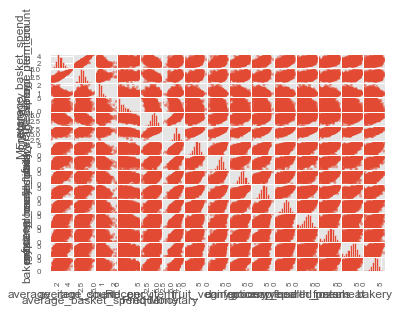

In [100]:
scatter = pd.plotting.scatter_matrix(df_log)

# 2. A Customer Base Summary section

In [101]:
df_ori.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,,,,,,,
14,9.48,12.07,1.27,1,56,675.72,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
45,19.85,17.75,0.89,1,33,585.73,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
52,4.98,3.77,0.76,2,59,222.18,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
61,13.49,14.81,1.10,3,37,547.87,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
63,5.85,6.11,1.04,7,48,293.34,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


In [102]:
df_ori.describe()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000
mean,11.273407,14.801243,1.394923,8.121333,65.182333,769.412937,69.456163,71.302683,57.347793,60.007530,60.909867,35.48057,35.466020,54.740687,38.210123
std,8.538014,11.161381,0.567371,20.938531,47.464717,552.769022,70.499654,57.966265,55.959350,57.682533,69.805023,41.24047,41.477609,67.802126,36.496115
min,1.200000,1.460000,0.560000,0.000000,1.000000,7.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,6.117500,8.037500,1.070000,0.000000,32.000000,406.120000,22.695000,31.390000,21.070000,21.087500,18.145000,8.70000,8.777500,12.640000,14.635000
50%,8.730000,11.770000,1.250000,2.000000,53.000000,627.170000,50.935000,56.875000,42.290000,44.030000,39.075000,23.09500,22.275000,32.930000,29.270000
75%,13.390000,17.440000,1.530000,6.000000,86.000000,957.675000,93.405000,95.327500,75.125000,80.922500,77.250000,47.33000,47.237500,72.380000,50.050000
max,90.750000,152.620000,7.920000,164.000000,374.000000,6588.650000,1262.970000,708.040000,614.370000,1017.070000,884.450000,454.29000,385.800000,713.280000,444.370000


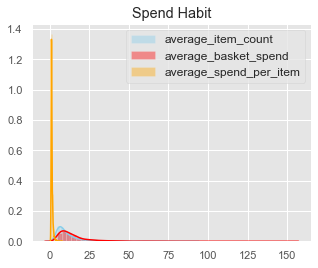

In [103]:
fig = plt.figure(figsize=(5,4))
sns.distplot(df_ori.average_item_count,color='skyblue',label='average_item_count')
sns.distplot(df_ori.average_basket_spend,color='red',label='average_basket_spend')
sns.distplot(df_ori.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Spend Habit')
plt.xlabel('')
plt.show()

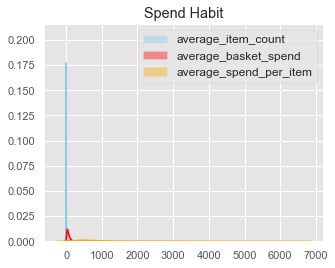

In [104]:
fig = plt.figure(figsize=(5,4))
sns.distplot(df_ori.Recency,color='skyblue',label='average_item_count')
sns.distplot(df_ori.Frequency,color='red',label='average_basket_spend')
sns.distplot(df_ori.Monetary,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Spend Habit')
plt.xlabel('')
plt.show()

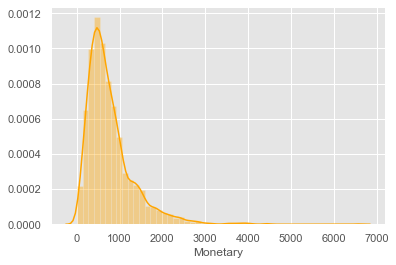

In [105]:
sns.distplot(df_ori.Monetary,color='orange',label='average_spend_per_item')

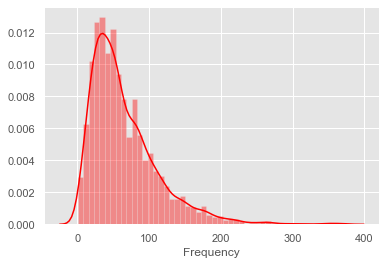

In [106]:
sns.distplot(df_ori.Frequency,color='red',label='average_basket_spend')

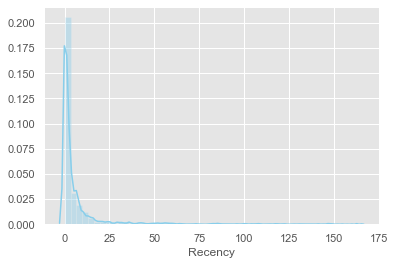

In [107]:
sns.distplot(df_ori.Recency,color='skyblue',label='average_item_count')

Text(0.5, 1.0, 'Seg6 (573)')

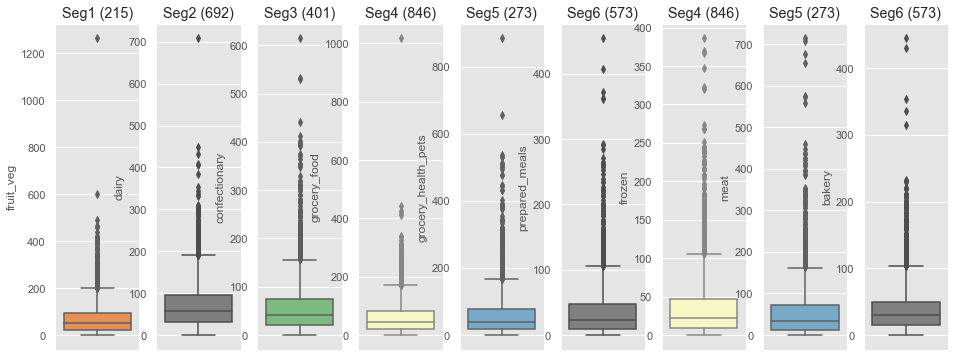

In [108]:
figure, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9)
figure.set_size_inches(16,6)

sns.boxplot(df_ori.fruit_veg, ax=ax1, orient = 'v', palette='Oranges'
           ).set_title('Seg1 (215)')
sns.boxplot(df_ori.dairy, ax=ax2, orient = 'v', palette='binary'
           ).set_title('Seg2 (692)')
sns.boxplot(df_ori.confectionary, ax=ax3, orient = 'v', palette='Greens'
           ).set_title('Seg3 (401)')
sns.boxplot(df_ori.grocery_food, ax=ax4, orient = 'v', palette='Spectral'
           ).set_title('Seg4 (846)')
sns.boxplot(df_ori.grocery_health_pets, ax=ax5, orient = 'v', palette='Blues'
           ).set_title('Seg5 (273)')
sns.boxplot(df_ori.prepared_meals, ax=ax6, orient = 'v', palette='gist_gray'
           ).set_title('Seg6 (573)')
sns.boxplot(df_ori.frozen, ax=ax7, orient = 'v', palette='Spectral'
           ).set_title('Seg4 (846)')
sns.boxplot(df_ori.meat, ax=ax8, orient = 'v', palette='Blues'
           ).set_title('Seg5 (273)')
sns.boxplot(df_ori.bakery, ax=ax9, orient = 'v', palette='gist_gray'
           ).set_title('Seg6 (573)')



# 3. Rescaling to remove the units

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)

# transform into a dataframe
df_scaled = pd.DataFrame(df_scaled, index=df_log.index, columns=df_log.columns)

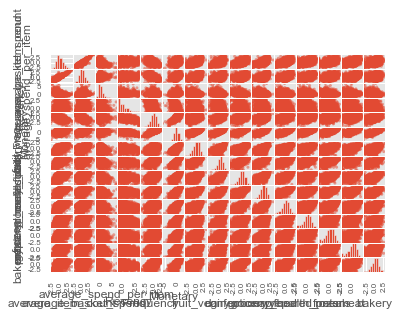

In [110]:
scatter = pd.plotting.scatter_matrix(df_scaled)

In [111]:
round(df_scaled.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.86,-3.05,-2.10,-1.00,-4.40,-6.14,-3.49,-4.35,-3.70,-3.64,-3.09,-2.43,-2.44,-2.44,-3.34
25%,-0.70,-0.70,-0.64,-1.00,-0.61,-0.58,-0.57,-0.52,-0.57,-0.59,-0.54,-0.59,-0.58,-0.52,-0.53
50%,-0.12,-0.08,-0.21,-0.09,0.06,0.03,0.15,0.12,0.11,0.12,0.10,0.15,0.12,0.14,0.14
75%,0.59,0.58,0.39,0.61,0.70,0.64,0.70,0.68,0.68,0.71,0.68,0.72,0.72,0.71,0.67
max,4.00,4.40,6.88,3.22,2.68,3.38,3.10,2.88,2.80,3.19,2.77,2.53,2.41,2.38,2.88


# 4. Feature Engineering

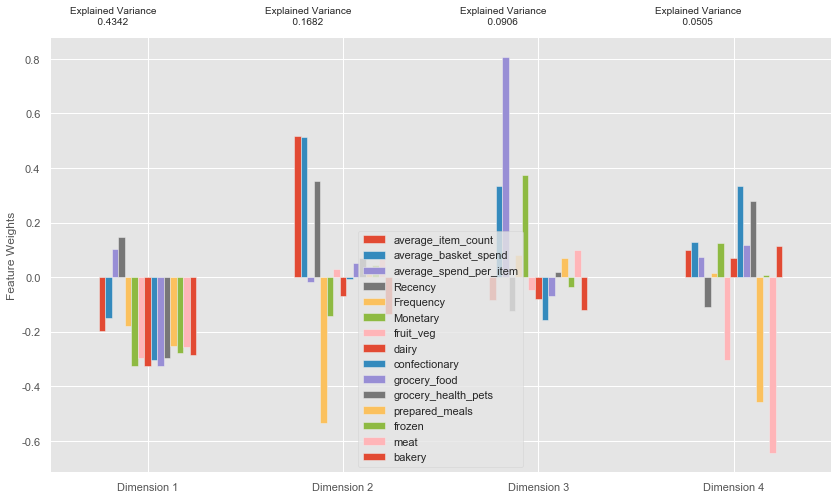

In [112]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
fit = pca.fit(df_scaled)

#-- import a helpful set of functions to ease displaying results..
import renders as rs

#-- Generate a PCA results plot 
pca_results = rs.pca_results(df_scaled, pca)

# 5. Selecting our final Features

In [113]:
pca.explained_variance_ratio_

count = 0 
explained = 0
for i in pca.explained_variance_ratio_:
    if explained < 0.70:
        explained += i
        count += 1
    else: 
        break
print(explained)
print(count)

0.7435166512965233
4


In [114]:
pca = PCA(n_components=4)
pca.fit(df_scaled)
reduced_data = pca.transform(df_scaled)
reduced_data = pd.DataFrame(reduced_data)

# 6. K-Means Clustering Algorithm

In [115]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

For n_clusters = 2.The average silhouette_score is : 0.31)


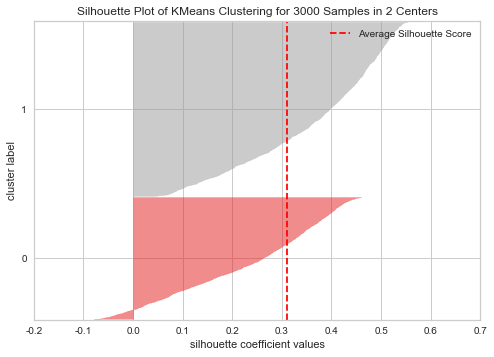

For n_clusters = 3.The average silhouette_score is : 0.241)


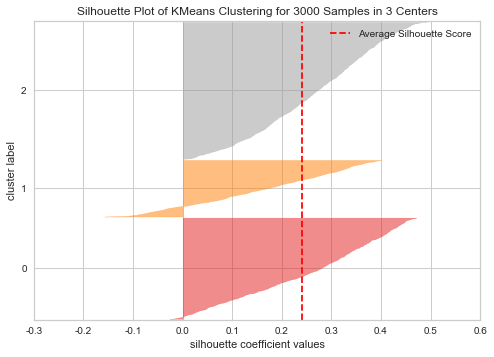

For n_clusters = 4.The average silhouette_score is : 0.236)


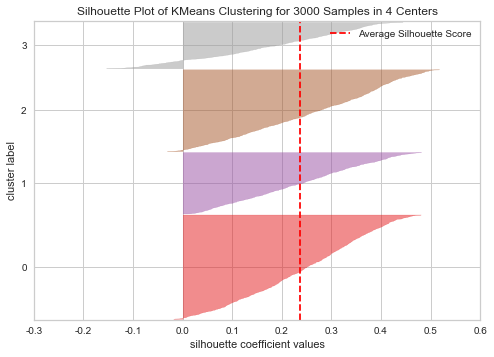

For n_clusters = 5.The average silhouette_score is : 0.222)


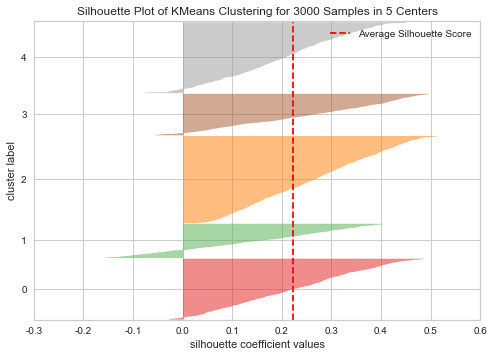

For n_clusters = 6.The average silhouette_score is : 0.228)


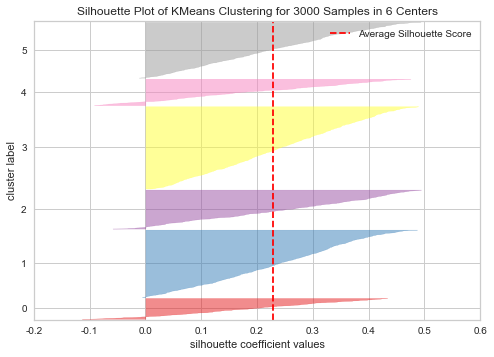

For n_clusters = 7.The average silhouette_score is : 0.208)


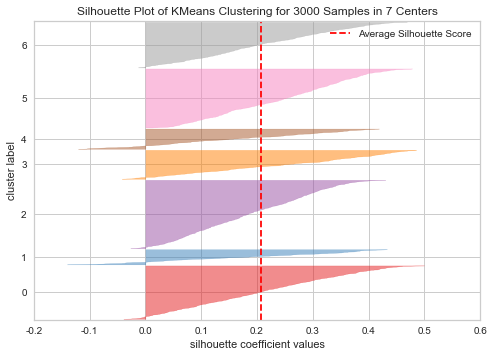

For n_clusters = 8.The average silhouette_score is : 0.216)


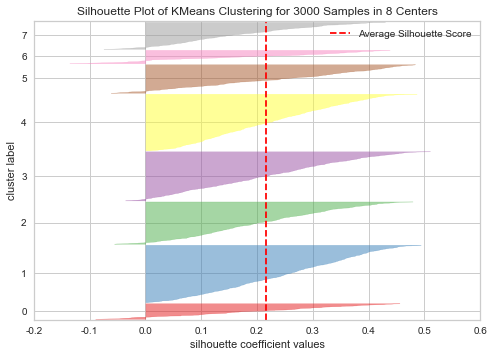

For n_clusters = 9.The average silhouette_score is : 0.212)


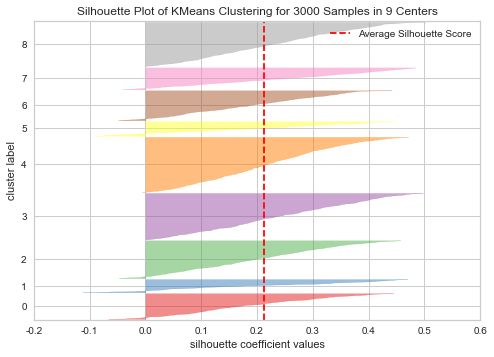

For n_clusters = 10.The average silhouette_score is : 0.205)


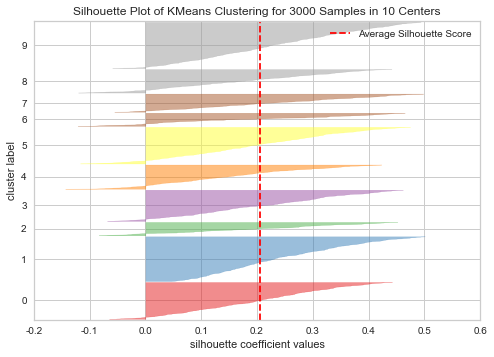

In [116]:
# Finding the right number of segments
for k in range(2,11):
    clusterer = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.cluster_centers_
    score = round(silhouette_score(reduced_data, preds, metric='euclidean'),3)
    
    print("For n_clusters = {}.The average silhouette_score is : {})".format(k, score)) 
    visualizer = SilhouetteVisualizer(clusterer, n_clusters=k)
    visualizer.fit(reduced_data)       
    visualizer.show()                                                       

# 7. K-Means Clustering Visualisation

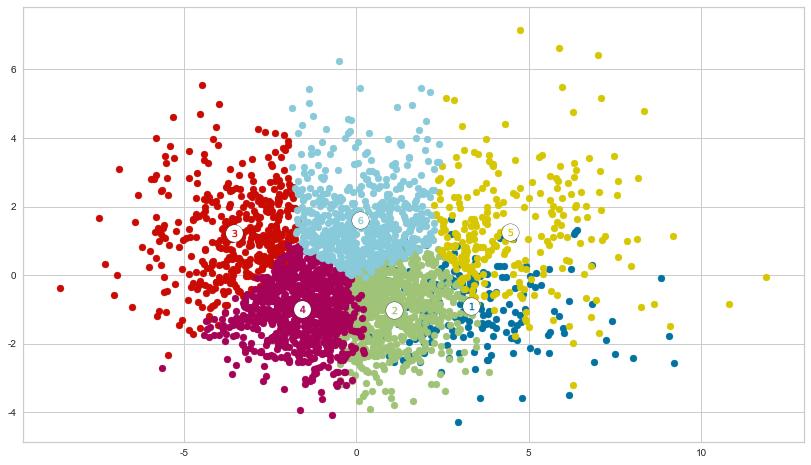

In [117]:
clusterer = KMeans(n_clusters=6, random_state=42).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centres = clusterer.cluster_centers_

#-- Put the predictions into a pandas dataframe format
assignments = pd.DataFrame(preds, columns = ['Cluster'])

#-- Put the predictions into a pandas dataframe format
plot_data = pd.concat([assignments, reduced_data], axis = 1)

#-- Color the points based on assigned cluster (n.b scatter will do this for us automatically)
plt.rcParams['figure.figsize'] = (14.0, 8.0)


for i, c in plot_data.groupby('Cluster'):  
    plt.scatter(c[0], c[1])
    
#-- Plot where the cluster centers are
for i, c in enumerate(centres):
    plt.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', marker = 'o', s=300);
    plt.scatter(x = c[0], y = c[1], marker='${}$'.format(i+1), alpha = 1, s=50);

# 8. Recovering Segment Archetypes in the original variables

In [118]:
log_centres = pca.inverse_transform(centres)

# TODO: Exponentiate the centres
true_centres = np.exp(log_centres)

#-- Display the true centres
segments = ['Segment {}'.format(i+1) for i in range(0, len(centres))]
true_centres = pd.DataFrame(np.round(true_centres), columns = df_log.columns)
true_centres.index = segments
print(true_centres)

           average_item_count  average_basket_spend  average_spend_per_item  \
Segment 1                 0.0                   1.0                     9.0   
Segment 2                 1.0                   0.0                     1.0   
Segment 3                 4.0                   4.0                     1.0   
Segment 4                 1.0                   1.0                     1.0   
Segment 5                 1.0                   1.0                     1.0   
Segment 6                 2.0                   2.0                     1.0   

           Recency  Frequency  Monetary  fruit_veg  dairy  confectionary  \
Segment 1      1.0        1.0       1.0        0.0    0.0            0.0   
Segment 2      1.0        1.0       1.0        1.0    1.0            1.0   
Segment 3      1.0        1.0       3.0        3.0    3.0            3.0   
Segment 4      1.0        2.0       2.0        2.0    2.0            2.0   
Segment 5      3.0        0.0       0.0        0.0    0.0         

# 9. Creating Profiles

In [119]:
final_assigments = pd.concat([assignments, df_ori], axis = 1)

#-- Create a loop that describes summary statistics for each segment
for c, d in final_assigments.groupby('Cluster'):
    print('SEGMENT', c+1)
    display(d.describe())

SEGMENT 1.0


,Cluster,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,215.0,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.0,14.242195,18.270244,1.380488,4.463415,54.073171,776.956829,73.946585,87.002439,55.846585,70.840000,78.154146,44.286098,38.332195,65.542683,41.618293
std,0.0,10.939258,12.894356,0.507691,7.043073,38.240287,466.912131,56.972023,58.610881,41.981152,53.646212,93.998123,40.181784,32.342403,65.618217,30.106793
min,0.0,4.450000,3.610000,0.770000,0.000000,7.000000,166.050000,3.590000,7.280000,11.040000,10.040000,10.460000,2.680000,8.090000,0.970000,6.040000
25%,0.0,7.130000,9.770000,1.140000,0.000000,30.000000,457.460000,31.660000,41.380000,23.560000,31.550000,23.640000,16.170000,13.580000,18.210000,19.400000
50%,0.0,10.960000,15.560000,1.290000,2.000000,41.000000,660.160000,64.740000,65.420000,44.730000,55.670000,58.660000,29.050000,32.120000,43.640000,38.900000
75%,0.0,17.610000,20.620000,1.500000,6.000000,64.000000,946.350000,99.330000,119.170000,65.610000,97.730000,94.630000,57.980000,50.560000,78.700000,54.340000
max,0.0,55.150000,65.800000,3.650000,36.000000,183.000000,2425.460000,218.190000,239.680000,173.380000,233.440000,538.200000,176.600000,161.220000,280.930000,162.870000


SEGMENT 2.0


,Cluster,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,692.0,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,1.0,12.361420,14.399198,1.193457,9.302469,59.462963,638.816975,74.010864,69.967037,52.561914,60.582716,52.955494,33.988272,38.559877,53.660370,38.355741
std,0.0,10.031834,12.084743,0.315331,25.969186,42.377209,353.109692,63.601607,49.812143,43.378947,49.819511,50.020320,31.249779,39.969966,51.768501,33.002259
min,1.0,2.530000,3.170000,0.590000,0.000000,1.000000,47.480000,0.000000,1.360000,0.000000,1.330000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.0,6.700000,7.442500,1.022500,0.000000,29.000000,378.425000,25.530000,31.217500,24.360000,24.330000,21.770000,11.925000,11.365000,16.940000,13.960000
50%,1.0,9.670000,12.040000,1.160000,1.000000,49.000000,564.220000,56.740000,58.260000,43.745000,45.250000,40.125000,24.225000,25.975000,37.430000,29.115000
75%,1.0,14.375000,15.945000,1.300000,5.750000,79.000000,847.452500,97.435000,101.012500,73.055000,84.350000,65.485000,48.487500,52.655000,73.875000,52.685000
max,1.0,83.250000,100.480000,2.700000,161.000000,218.000000,2119.470000,316.870000,264.600000,253.710000,303.680000,316.620000,150.710000,250.480000,234.380000,162.600000


SEGMENT 3.0


,Cluster,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,401.0,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,2.0,12.997568,15.823919,1.225811,8.040541,60.013514,773.663243,87.059459,84.269189,69.393784,69.479459,73.122162,41.450135,37.358243,65.920000,44.535811
std,0.0,9.317250,12.121332,0.347701,24.864256,37.910310,515.253812,92.642031,56.803068,61.769538,60.916403,72.850189,33.695472,36.549954,65.938341,49.843267
min,2.0,4.590000,4.610000,0.700000,0.000000,6.000000,69.470000,0.000000,10.600000,3.340000,3.240000,3.390000,0.590000,1.640000,1.590000,3.370000
25%,2.0,6.630000,8.035000,1.010000,0.000000,34.250000,429.380000,36.167500,41.045000,25.970000,24.685000,20.360000,16.342500,11.617500,16.737500,20.512500
50%,2.0,10.175000,11.880000,1.175000,1.000000,52.000000,621.375000,57.630000,73.865000,50.585000,55.525000,41.790000,38.740000,29.435000,47.525000,32.825000
75%,2.0,16.452500,18.967500,1.357500,3.750000,74.000000,932.075000,94.515000,108.137500,92.767500,91.840000,109.127500,51.167500,47.855000,88.940000,49.307500
max,2.0,44.710000,59.060000,2.940000,146.000000,207.000000,2244.340000,462.780000,300.000000,350.370000,301.880000,306.940000,172.540000,158.560000,309.960000,353.050000


SEGMENT 4.0


,Cluster,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,846.0,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,3.0,11.436014,14.105405,1.244189,7.547297,61.621622,702.204932,76.075068,77.418446,59.539662,61.608581,59.281622,42.224932,40.395676,59.051419,42.760676
std,0.0,7.323582,9.516259,0.358405,17.640142,41.028181,452.041850,74.013548,57.415576,53.085169,57.868964,63.406364,36.698710,45.864548,64.464679,37.940471
min,3.0,2.140000,2.070000,0.620000,0.000000,5.000000,113.930000,0.000000,0.000000,1.500000,2.190000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.0,7.030000,7.967500,1.020000,0.000000,30.000000,400.677500,29.965000,33.852500,24.875000,22.180000,21.600000,15.245000,12.965000,15.952500,16.967500
50%,3.0,9.460000,11.005000,1.175000,1.000000,52.500000,589.870000,61.845000,67.915000,45.395000,43.200000,35.920000,33.820000,27.205000,41.175000,32.500000
75%,3.0,13.527500,17.245000,1.365000,6.000000,80.000000,917.815000,88.610000,104.882500,74.330000,83.037500,71.770000,58.642500,53.012500,81.015000,56.092500
max,3.0,52.960000,58.020000,2.920000,108.000000,229.000000,2785.030000,412.140000,260.040000,347.940000,412.780000,380.550000,220.280000,385.800000,436.460000,220.770000


SEGMENT 5.0


,Cluster,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,273.0,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.00000
mean,4.0,14.318864,17.841591,1.242955,6.818182,46.795455,671.732273,81.734318,77.034318,57.188409,63.315682,68.075227,34.013864,44.296364,62.520909,39.09000
std,0.0,13.791487,19.642670,0.259531,8.734515,23.481392,470.111388,78.417680,57.181119,54.701571,57.939297,90.901370,33.599052,61.588839,77.604481,39.84454
min,4.0,4.320000,4.570000,0.720000,0.000000,11.000000,131.070000,0.000000,8.350000,5.180000,5.990000,1.490000,1.180000,0.000000,1.290000,3.24000
25%,4.0,7.155000,9.212500,1.057500,1.000000,28.750000,399.577500,25.225000,38.160000,27.187500,22.687500,23.632500,10.472500,13.627500,12.130000,18.02000
50%,4.0,10.460000,11.900000,1.220000,3.000000,44.500000,538.455000,61.150000,52.670000,42.185000,50.770000,33.885000,24.260000,21.930000,31.590000,27.81500
75%,4.0,15.042500,17.632500,1.400000,8.000000,60.000000,719.152500,109.952500,111.635000,69.585000,79.327500,65.052500,47.992500,45.952500,77.990000,40.04750
max,4.0,84.270000,122.160000,2.060000,33.000000,117.000000,2177.420000,403.030000,266.710000,310.710000,285.570000,478.550000,159.190000,320.590000,397.580000,201.19000


SEGMENT 6.0


,Cluster,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,573.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,5.0,12.845960,15.773535,1.213333,7.626263,55.828283,637.704141,76.099798,67.709293,60.541414,57.561414,50.709192,40.359798,38.246869,52.745253,39.389192
std,0.0,11.540094,15.660396,0.485187,19.139971,41.055721,383.940301,64.967942,45.873121,52.132768,49.409803,56.027141,45.895815,37.500820,54.678562,30.355814
min,5.0,3.340000,3.000000,0.740000,0.000000,6.000000,81.760000,2.380000,4.980000,1.460000,1.080000,0.860000,0.800000,1.780000,0.870000,0.000000
25%,5.0,7.295000,8.275000,0.980000,0.000000,31.500000,373.050000,37.400000,33.725000,29.245000,22.475000,16.545000,9.205000,13.610000,19.465000,16.920000
50%,5.0,9.740000,11.650000,1.160000,2.000000,44.000000,540.350000,55.970000,60.900000,43.930000,41.260000,35.290000,24.230000,27.100000,35.180000,31.940000
75%,5.0,13.615000,16.905000,1.340000,6.000000,65.000000,790.130000,97.405000,91.990000,71.985000,81.445000,56.335000,50.175000,50.230000,65.840000,55.205000
max,5.0,90.750000,116.950000,5.390000,136.000000,258.000000,1857.650000,307.290000,224.560000,320.000000,289.020000,289.060000,257.350000,184.620000,281.640000,140.120000


## 9-1. Creating separate segment groups

In [120]:
clusterer.cluster_centers_

array([[ 3.31068845, -0.91519372,  2.25887105,  0.32842058],
       [ 1.07953272, -1.01377763, -0.59529118,  0.00707423],
       [-3.53367494,  1.22387084,  0.35401291,  0.13904307],
       [-1.5648163 , -0.99927423,  0.02003483, -0.11691016],
       [ 4.45004631,  1.24500303, -0.59869795, -0.14627162],
       [ 0.11717441,  1.59341838, -0.12073277,  0.01322179]])

In [121]:
clusterer.labels_

array([3, 5, 4, ..., 1, 5, 5])

In [122]:
mydict = {i: np.where(clusterer.labels_ == i)[0] for i in range(clusterer.n_clusters)}

In [123]:
mydict

{0: array([  56,   81,  131,  140,  180,  260,  267,  432,  439,  465,  556,
         578,  655,  667,  672,  735,  759,  815,  833,  847,  849,  858,
         872,  882,  888,  916,  928,  934,  937,  941,  943,  957,  960,
         969,  977,  978,  982,  985,  998, 1025, 1045, 1052, 1060, 1067,
        1068, 1077, 1083, 1112, 1128, 1152, 1161, 1166, 1171, 1180, 1194,
        1204, 1208, 1211, 1229, 1237, 1238, 1268, 1271, 1285, 1287, 1289,
        1309, 1319, 1356, 1425, 1426, 1438, 1445, 1455, 1486, 1556, 1598,
        1615, 1622, 1643, 1679, 1680, 1766, 1770, 1776, 1777, 1778, 1782,
        1792, 1794, 1820, 1830, 1835, 1870, 1912, 1959, 1974, 1992, 2064,
        2124, 2137, 2176, 2179, 2180, 2182, 2184, 2192, 2194, 2197, 2201,
        2202, 2203, 2207, 2209, 2213, 2214, 2219, 2223, 2224, 2226, 2244,
        2259, 2260, 2261, 2268, 2271, 2287, 2291, 2333, 2351, 2357, 2370,
        2383, 2386, 2399, 2418, 2429, 2431, 2433, 2445, 2464, 2468, 2508,
        2528, 2542, 2550, 2561, 256

In [124]:
dictlist = []
for key, value in mydict.items():
    temp = [key,value]
    dictlist.append(temp)

In [125]:
dictlist

[[0, array([  56,   81,  131,  140,  180,  260,  267,  432,  439,  465,  556,
          578,  655,  667,  672,  735,  759,  815,  833,  847,  849,  858,
          872,  882,  888,  916,  928,  934,  937,  941,  943,  957,  960,
          969,  977,  978,  982,  985,  998, 1025, 1045, 1052, 1060, 1067,
         1068, 1077, 1083, 1112, 1128, 1152, 1161, 1166, 1171, 1180, 1194,
         1204, 1208, 1211, 1229, 1237, 1238, 1268, 1271, 1285, 1287, 1289,
         1309, 1319, 1356, 1425, 1426, 1438, 1445, 1455, 1486, 1556, 1598,
         1615, 1622, 1643, 1679, 1680, 1766, 1770, 1776, 1777, 1778, 1782,
         1792, 1794, 1820, 1830, 1835, 1870, 1912, 1959, 1974, 1992, 2064,
         2124, 2137, 2176, 2179, 2180, 2182, 2184, 2192, 2194, 2197, 2201,
         2202, 2203, 2207, 2209, 2213, 2214, 2219, 2223, 2224, 2226, 2244,
         2259, 2260, 2261, 2268, 2271, 2287, 2291, 2333, 2351, 2357, 2370,
         2383, 2386, 2399, 2418, 2429, 2431, 2433, 2445, 2464, 2468, 2508,
         2528, 2542, 2

In [126]:
df_ori.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,,,,,,,
14,9.48,12.07,1.27,1,56,675.72,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
45,19.85,17.75,0.89,1,33,585.73,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
52,4.98,3.77,0.76,2,59,222.18,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
61,13.49,14.81,1.10,3,37,547.87,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
63,5.85,6.11,1.04,7,48,293.34,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


In [127]:
df_ori = df_ori.rename_axis(columns = None).reset_index()

In [128]:
df_ori.head()

,customer_number,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
0,14,9.48,12.07,1.27,1,56,675.72,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
1,45,19.85,17.75,0.89,1,33,585.73,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
2,52,4.98,3.77,0.76,2,59,222.18,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
3,61,13.49,14.81,1.10,3,37,547.87,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
4,63,5.85,6.11,1.04,7,48,293.34,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


In [129]:
df_ori = df_ori.copy()

In [130]:
df_ori.insert(loc=0, column='number', value=np.arange(len(df_ori)))

In [131]:
df_ori.head()

,number,customer_number,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
0,0,14,9.48,12.07,1.27,1,56,675.72,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
1,1,45,19.85,17.75,0.89,1,33,585.73,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
2,2,52,4.98,3.77,0.76,2,59,222.18,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
3,3,61,13.49,14.81,1.10,3,37,547.87,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
4,4,63,5.85,6.11,1.04,7,48,293.34,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35


In [132]:
clu1 = dictlist[0]
clu1 = pd.DataFrame(clu1)
clu1 = clu1.drop([0])
clu1 = [i[0] for i in clu1.values.tolist()]
[clu1] = clu1
clu1 = clu1.tolist()
clu1[0:4]

[56, 81, 131, 140]

In [133]:
clu2 = dictlist[1]
clu2 = pd.DataFrame(clu2)
clu2 = clu2.drop([0])
clu2 = [i[0] for i in clu2.values.tolist()]
[clu2] = clu2
clu2 = clu2.tolist()
clu2[0:4]

[4, 11, 12, 15]

In [134]:
clu3 = dictlist[2]
clu3 = pd.DataFrame(clu3)
clu3 = clu3.drop([0])
clu3 = [i[0] for i in clu3.values.tolist()]
[clu3] = clu3
clu3 = clu3.tolist()
clu3[0:4]

[5, 7, 20, 26]

In [135]:
clu4 = dictlist[3]
clu4 = pd.DataFrame(clu4)
clu4 = clu4.drop([0])
clu4 = [i[0] for i in clu4.values.tolist()]
[clu4] = clu4
clu4 = clu4.tolist()
clu4[0:4]

[0, 10, 14, 16]

In [136]:
clu5 = dictlist[4]
clu5 = pd.DataFrame(clu5)
clu5 = clu5.drop([0])
clu5 = [i[0] for i in clu5.values.tolist()]
[clu5] = clu5
clu5 = clu5.tolist()
clu5[0:4]

[2, 13, 23, 42]

In [137]:
clu6 = dictlist[5]
clu6 = pd.DataFrame(clu6)
clu6 = clu6.drop([0])
clu6 = [i[0] for i in clu6.values.tolist()]
[clu6] = clu6
clu6 = clu6.tolist()
clu6[0:4]

[1, 3, 6, 8]

## 9-2. Six segments

In [138]:
seg1 = df_ori.loc[df_ori['number'].isin(clu1)]
seg1 = seg1.drop(columns=['number','customer_number'])
seg1.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
56,3.98,6.39,1.60,0,54,344.85,18.78,4.32,10.16,22.99,13.05,35.36,5.97,25.20,3.92
81,4.59,13.50,2.94,3,37,499.53,0.63,29.03,10.36,8.80,19.33,9.37,6.13,8.44,4.09
131,9.00,15.60,1.73,1,36,561.42,14.69,18.41,6.53,3.47,23.08,9.16,4.98,47.19,17.88
140,3.51,9.70,2.76,3,86,834.38,57.21,22.39,1.50,32.01,17.33,56.52,6.99,90.13,3.03
180,4.45,16.28,3.65,6,66,1074.51,24.34,40.33,11.04,48.06,74.29,19.02,37.22,0.97,6.04


In [139]:
seg2 = df_ori.loc[df_ori['number'].isin(clu2)]
seg2 = seg2.drop(columns=['number','customer_number'])
seg2.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
4,5.85,6.11,1.04,7,48,293.34,22.01,42.11,73.07,13.54,25.08,13.38,14.53,3.46,33.35
11,4.84,8.97,1.85,1,67,600.74,77.48,97.87,24.96,37.07,1.44,33.83,25.44,5.28,14.32
12,7.15,12.06,1.69,2,46,554.54,50.91,12.97,4.87,44.19,49.28,11.07,33.70,40.62,14.05
15,6.75,9.18,1.36,0,48,440.71,76.17,104.84,25.94,27.69,11.21,49.78,10.46,14.79,16.97
21,8.51,7.78,0.91,1,39,303.53,55.90,75.89,39.61,28.05,23.64,4.43,13.15,18.21,8.81


In [140]:
seg3 = df_ori.loc[df_ori['number'].isin(clu3)]
seg3 = seg3.drop(columns=['number','customer_number'])
seg3.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
5,23.44,35.20,1.50,2,45,1584.18,267.48,118.83,126.38,122.67,194.14,20.64,11.13,134.67,71.33
7,23.10,29.38,1.27,3,42,1233.78,195.01,58.85,222.11,176.19,129.99,0.49,30.32,141.86,90.33
20,44.71,52.11,1.17,18,14,729.55,128.11,83.87,103.35,58.14,76.64,51.46,18.37,58.75,42.45
26,21.96,33.78,1.54,2,55,1857.65,223.38,70.08,176.93,289.02,87.48,107.95,26.19,52.54,70.50
46,16.59,21.25,1.28,6,63,1338.67,180.61,151.08,166.60,177.09,316.62,31.38,83.03,76.00,68.31


In [141]:
seg4 = df_ori.loc[df_ori['number'].isin(clu4)]
seg4 = seg4.drop(columns=['number','customer_number'])
seg4.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
0,9.48,12.07,1.27,1,56,675.72,11.10,172.58,23.22,56.05,11.28,23.36,25.29,182.37,18.09
10,8.19,9.78,1.19,6,53,518.58,28.65,66.43,96.06,55.88,44.08,47.74,43.32,46.26,19.85
14,9.68,13.27,1.37,0,40,530.64,42.78,43.17,34.22,67.97,8.27,34.21,38.56,28.05,47.33
16,10.29,10.83,1.05,1,79,855.23,182.11,204.10,57.26,30.28,125.11,6.97,52.80,99.48,42.59
19,8.17,12.97,1.59,4,54,700.34,24.79,38.96,49.51,30.94,21.69,59.42,29.58,74.54,37.35


In [142]:
seg5 = df_ori.loc[df_ori['number'].isin(clu5)]
seg5 = seg5.drop(columns=['number','customer_number'])
seg5.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
2,4.98,3.77,0.76,2,59,222.18,53.29,5.19,3.29,1.08,12.11,2.78,1.78,9.74,2.45
13,7.03,5.07,0.72,93,35,177.29,20.87,24.00,9.92,8.33,7.57,20.58,12.11,20.39,15.61
23,13.64,14.97,1.10,52,11,164.66,11.14,16.88,28.97,21.39,14.90,11.12,13.52,28.92,10.70
42,12.78,16.47,1.29,2,9,148.25,9.29,25.71,19.56,12.87,29.30,17.25,0.85,17.63,8.65
53,18.88,20.25,1.07,30,8,162.03,28.16,28.17,12.02,16.45,10.40,12.54,7.43,5.98,8.06


In [143]:
seg6 = df_ori.loc[df_ori['number'].isin(clu6)]
seg6 = seg6.drop(columns=['number','customer_number'])
seg6.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
1,19.85,17.75,0.89,1,33,585.73,30.21,142.16,106.54,83.42,24.31,56.51,7.05,60.31,18.00
3,13.49,14.81,1.10,3,37,547.87,70.18,55.29,46.39,56.18,45.71,12.12,18.63,121.38,32.75
6,12.17,12.52,1.03,2,18,225.41,63.23,38.91,29.61,21.59,8.97,26.86,1.00,10.77,8.60
8,12.20,17.76,1.46,0,20,355.16,49.37,25.02,15.63,32.00,20.17,25.32,53.01,30.99,46.36
9,14.19,19.70,1.39,4,37,729.04,80.55,122.82,59.01,115.42,35.35,45.67,31.82,44.73,25.65


# 10. Individual statistical summaries of clusters 

In [144]:
round(seg1.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00
mean,4.79,12.62,2.68,3.86,63.86,712.61,16.76,24.11,15.49,17.61,16.33,12.12,8.92,18.94,13.67
std,1.80,6.71,1.00,9.72,37.55,414.09,15.90,19.40,15.60,21.26,19.86,18.47,14.32,42.94,13.04
min,1.37,3.02,1.17,0.00,9.00,156.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.52,8.24,2.04,0.00,38.00,423.95,5.70,10.34,5.24,5.78,3.58,2.34,1.67,1.79,4.66
50%,4.70,11.97,2.44,1.00,54.00,619.03,12.54,19.84,10.53,10.66,9.90,6.64,5.06,7.22,10.02
75%,5.77,14.76,3.05,3.00,80.00,852.73,22.45,32.58,20.72,20.74,22.34,14.39,11.26,21.91,19.34
max,10.07,57.32,7.92,82.00,266.00,2649.05,103.32,120.97,123.95,146.82,164.58,165.94,113.55,407.27,77.39


In [145]:
seg1.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
56,3.98,6.39,1.60,0,54,344.85,18.78,4.32,10.16,22.99,13.05,35.36,5.97,25.20,3.92
81,4.59,13.50,2.94,3,37,499.53,0.63,29.03,10.36,8.80,19.33,9.37,6.13,8.44,4.09
131,9.00,15.60,1.73,1,36,561.42,14.69,18.41,6.53,3.47,23.08,9.16,4.98,47.19,17.88
140,3.51,9.70,2.76,3,86,834.38,57.21,22.39,1.50,32.01,17.33,56.52,6.99,90.13,3.03
180,4.45,16.28,3.65,6,66,1074.51,24.34,40.33,11.04,48.06,74.29,19.02,37.22,0.97,6.04


In [146]:
print(seg1.Monetary.describe())
print(seg2.Monetary.describe())
print(seg3.Monetary.describe())
print(seg4.Monetary.describe())
print(seg5.Monetary.describe())
print(seg6.Monetary.describe())

count     215.000000
mean      712.611721
std       414.090293
min       156.610000
25%       423.950000
50%       619.030000
75%       852.735000
max      2649.050000
Name: Monetary, dtype: float64
count     692.000000
mean      484.672803
std       190.249905
min       178.880000
25%       351.280000
50%       446.990000
75%       574.110000
max      1460.410000
Name: Monetary, dtype: float64
count     401.000000
mean     1518.787332
std       725.349756
min       607.930000
25%      1014.820000
50%      1337.370000
75%      1854.140000
max      6588.650000
Name: Monetary, dtype: float64
count     846.000000
mean     1019.234504
std       432.587454
min       461.500000
25%       712.077500
50%       897.550000
75%      1219.970000
max      3491.780000
Name: Monetary, dtype: float64
count    273.000000
mean     181.860696
std       82.556699
min        7.280000
25%      126.420000
50%      177.290000
75%      225.690000
max      496.630000
Name: Monetary, dtype: float64
count     573

Text(0.5, 1.0, 'Seg6 (573)')

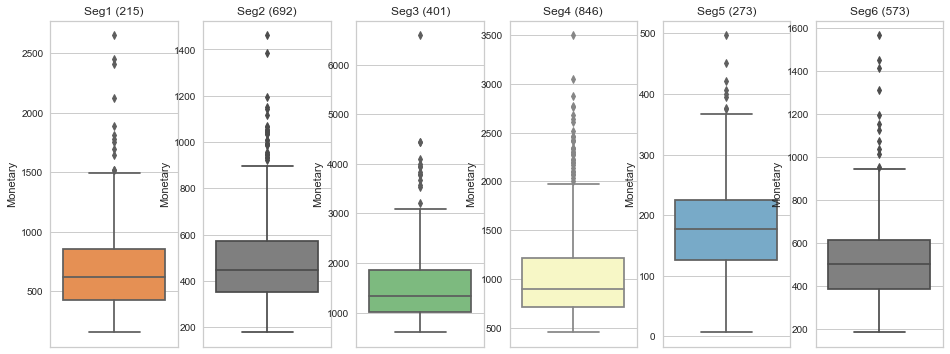

In [147]:
figure, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
figure.set_size_inches(16,6)

sns.boxplot(seg1.Monetary, ax=ax1, orient = 'v', palette='Oranges'
           ).set_title('Seg1 (215)')
sns.boxplot(seg2.Monetary, ax=ax2, orient = 'v', palette='binary'
           ).set_title('Seg2 (692)')
sns.boxplot(seg3.Monetary, ax=ax3, orient = 'v', palette='Greens'
           ).set_title('Seg3 (401)')
sns.boxplot(seg4.Monetary, ax=ax4, orient = 'v', palette='Spectral'
           ).set_title('Seg4 (846)')
sns.boxplot(seg5.Monetary, ax=ax5, orient = 'v', palette='Blues'
           ).set_title('Seg5 (273)')
sns.boxplot(seg6.Monetary, ax=ax6, orient = 'v', palette='gist_gray'
           ).set_title('Seg6 (573)')

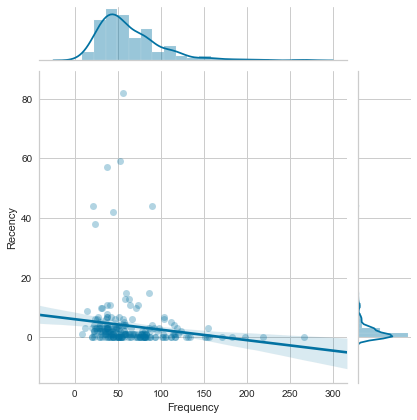

In [148]:
sns.jointplot(x='Frequency', y='Recency',  scatter_kws={'alpha':0.3}, kind='reg',
             data=seg1)

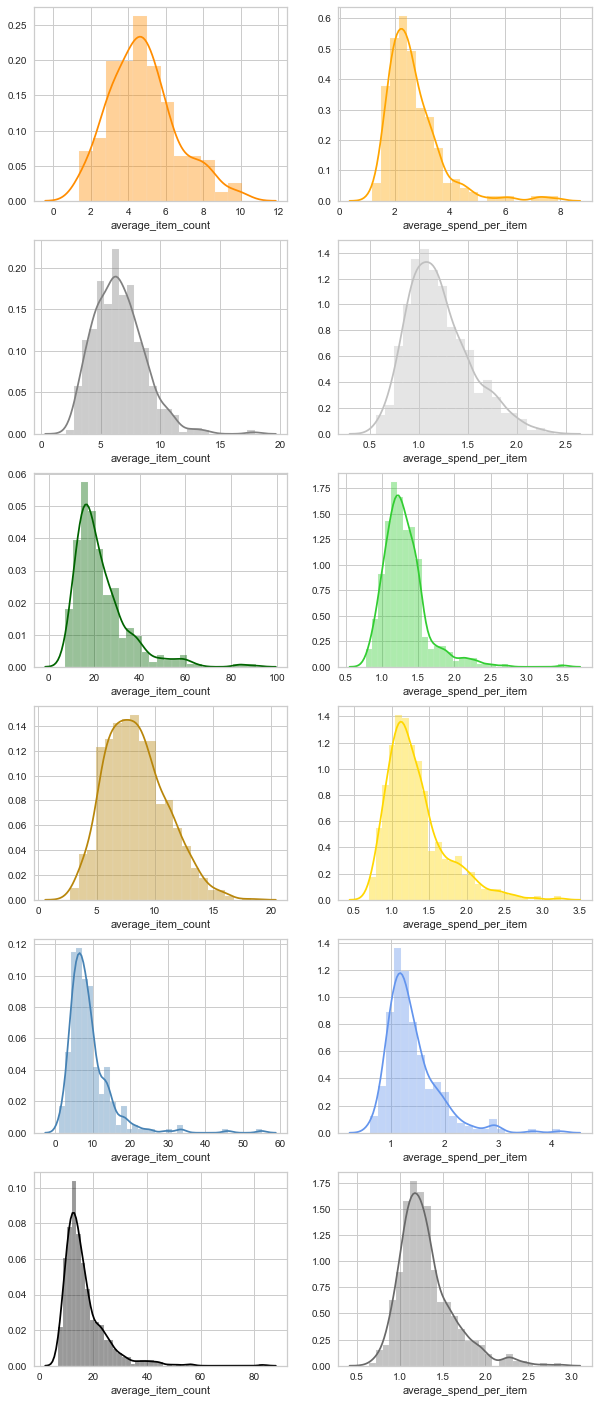

In [149]:
'''
item count - bakset spend 0.62
basket spend - item count 0.62
basket spend - spend per tiem 0.51
'''

figure, axes  = plt.subplots(6, 2)
figure.set_size_inches(10,25)

sns.distplot(seg1.average_item_count, 
             ax=axes[0][0],color='darkorange')
sns.distplot(seg1.average_spend_per_item, 
             ax=axes[0][1], color='orange')
sns.distplot(seg2.average_item_count, 
             ax=axes[1][0],color='gray')
sns.distplot(seg2.average_spend_per_item, 
             ax=axes[1][1],color='silver')

sns.distplot(seg3.average_item_count, 
             ax=axes[2][0],color='darkgreen')
sns.distplot(seg3.average_spend_per_item, 
             ax=axes[2][1],color='limegreen')

sns.distplot(seg4.average_item_count, 
             ax=axes[3][0],color='darkgoldenrod')
sns.distplot(seg4.average_spend_per_item, 
             ax=axes[3][1], color='gold')

sns.distplot(seg5.average_item_count, 
             ax=axes[4][0],color='steelblue')
sns.distplot(seg5.average_spend_per_item, 
             ax=axes[4][1], color='cornflowerblue')

sns.distplot(seg6.average_item_count, 
             ax=axes[5][0],color='black')
sns.distplot(seg6.average_spend_per_item, 
             ax=axes[5][1], color='dimgray')

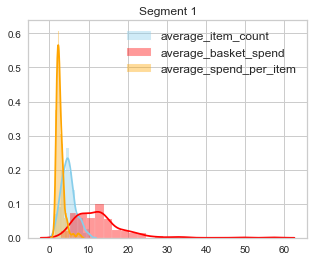

In [150]:
fig = plt.figure(figsize=(5,4))
sns.distplot(seg1.average_item_count,color='skyblue',label='average_item_count')
sns.distplot(seg1.average_basket_spend,color='red',label='average_basket_spend')
sns.distplot(seg1.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Segment 1')
plt.xlabel('')
plt.show()


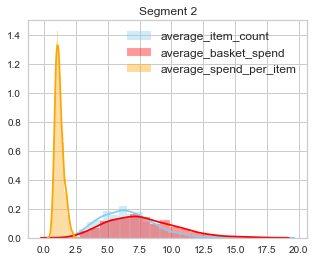

In [151]:
fig = plt.figure(figsize=(5,4))
sns.distplot(seg2.average_item_count,color='skyblue',label='average_item_count')
sns.distplot(seg2.average_basket_spend,color='red',label='average_basket_spend')
sns.distplot(seg2.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Segment 2')
plt.xlabel('')
plt.show()

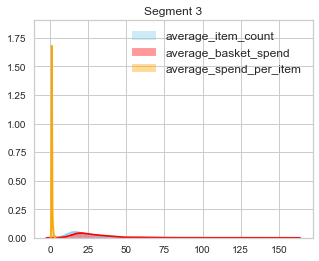

In [152]:
fig = plt.figure(figsize=(5,4))
sns.distplot(seg3.average_item_count,color='skyblue',label='average_item_count')
sns.distplot(seg3.average_basket_spend,color='red',label='average_basket_spend')
sns.distplot(seg3.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Segment 3')
plt.xlabel('')
plt.show()

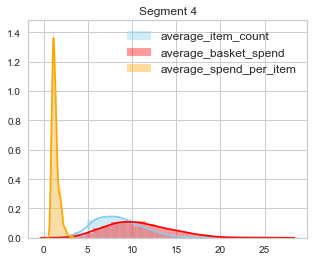

In [153]:
fig = plt.figure(figsize=(5,4))
sns.distplot(seg4.average_item_count,color='skyblue',label='average_item_count')
sns.distplot(seg4.average_basket_spend,color='red',label='average_basket_spend')
sns.distplot(seg4.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Segment 4')
plt.xlabel('')
plt.show()

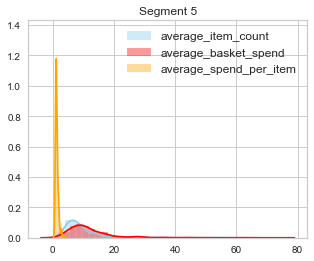

In [154]:
fig = plt.figure(figsize=(5,4))
sns.distplot(seg5.average_item_count,color='skyblue',label='average_item_count')
sns.distplot(seg5.average_basket_spend,color='red',label='average_basket_spend')
sns.distplot(seg5.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Segment 5')
plt.xlabel('')
plt.show()

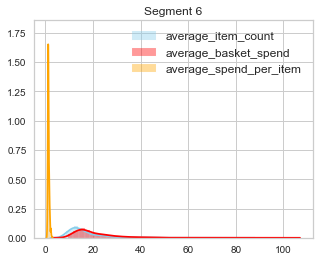

In [155]:
fig = plt.figure(figsize=(5,4))
sns.distplot(seg6.average_item_count,color='skyblue',
             label='average_item_count')
sns.distplot(seg6.average_basket_spend,color='red',
             label='average_basket_spend')
sns.distplot(seg6.average_spend_per_item,color='orange',label='average_spend_per_item')

plt.legend(prop={'size': 12})
plt.title('Segment 6')
plt.xlabel('')
plt.show()

In [156]:
round(seg2.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00,692.00
mean,6.53,7.69,1.21,4.44,69.93,484.67,43.68,49.13,36.67,33.19,30.45,19.15,18.56,25.53,29.05
std,2.12,2.69,0.32,12.53,37.08,190.25,35.74,29.49,25.45,24.88,27.06,18.86,18.10,24.96,19.53
min,2.14,2.07,0.56,0.00,22.00,178.88,0.00,2.07,0.00,1.33,0.00,0.00,0.00,0.00,0.00
25%,4.94,5.72,0.97,0.00,46.00,351.28,18.48,29.39,19.24,16.25,12.85,7.04,6.22,7.72,15.60
50%,6.32,7.40,1.16,1.00,59.00,446.99,34.97,42.42,30.53,26.64,24.08,14.74,14.20,18.34,24.81
75%,7.73,9.34,1.39,4.00,85.00,574.11,58.06,61.67,47.62,41.92,39.22,25.51,24.42,35.55,38.53
max,17.88,16.90,2.38,123.00,329.00,1460.41,254.37,194.30,178.92,174.82,285.57,234.63,129.83,177.09,159.96


In [157]:
round(seg3.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00,401.00
mean,23.02,29.58,1.32,4.07,62.57,1518.79,162.47,145.73,133.91,143.42,161.27,80.84,88.06,140.93,76.34
std,12.07,16.18,0.31,8.16,42.59,725.35,111.58,75.91,83.82,83.16,111.39,65.51,66.13,113.76,52.36
min,7.41,8.87,0.78,0.00,11.00,607.93,13.02,22.89,19.47,11.63,2.16,0.00,2.88,0.00,5.25
25%,15.17,19.22,1.12,0.00,35.00,1014.82,89.69,93.05,79.08,89.60,84.79,36.76,38.92,66.44,41.55
50%,19.65,25.05,1.26,1.00,52.00,1337.37,134.52,128.22,111.61,126.77,134.11,67.33,72.36,113.75,64.74
75%,27.64,35.01,1.44,4.00,78.00,1854.14,207.46,182.42,169.36,179.63,208.66,110.09,117.09,183.32,93.52
max,90.75,152.62,3.51,83.00,348.00,6588.65,1262.97,708.04,614.37,1017.07,884.45,454.29,385.80,713.28,430.50


In [158]:
round(seg4.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00,846.00
mean,8.38,10.77,1.32,1.70,102.85,1019.23,85.44,94.85,72.03,73.17,71.43,46.71,44.99,67.30,52.62
std,2.60,3.61,0.39,4.87,49.62,432.59,53.05,47.66,44.90,42.81,52.41,36.64,34.83,51.59,34.97
min,2.73,2.66,0.70,0.00,35.00,461.50,4.52,15.15,2.93,5.14,2.50,0.00,0.00,0.00,2.25
25%,6.42,8.18,1.06,0.00,67.00,712.08,46.17,62.25,42.96,43.53,35.91,22.14,21.40,29.91,30.96
50%,8.18,10.47,1.23,0.00,90.50,897.55,76.16,85.43,62.62,64.54,58.95,38.84,36.99,55.87,44.80
75%,9.93,13.02,1.48,2.00,125.75,1219.97,112.48,114.61,90.79,95.54,94.40,61.13,59.06,91.84,66.03
max,18.24,25.42,3.25,58.00,374.00,3491.78,332.41,353.51,412.27,425.36,512.64,362.96,268.39,351.48,444.37


In [159]:
round(seg5.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00,273.00
mean,9.03,12.11,1.39,38.72,19.66,181.86,14.79,16.40,15.02,13.03,14.64,7.84,7.52,12.95,7.90
std,6.05,8.57,0.48,44.76,13.00,82.56,12.65,11.83,12.02,11.78,18.13,8.58,8.63,19.11,6.06
min,1.20,1.46,0.60,0.00,1.00,7.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.51,7.30,1.07,5.00,11.00,126.42,5.32,7.42,6.39,4.78,3.30,1.29,1.59,2.34,3.04
50%,7.57,10.04,1.25,19.00,17.00,177.29,11.50,14.06,12.03,10.12,9.48,5.08,4.99,8.19,6.90
75%,10.44,14.16,1.56,59.00,26.00,225.69,20.85,23.16,19.55,18.34,17.84,11.34,10.63,17.59,10.92
max,55.00,73.75,4.15,164.00,100.00,496.63,67.87,68.04,60.56,61.99,127.85,42.64,49.96,190.83,32.53


In [160]:
round(seg6.describe(),2)

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
count,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00,573.00
mean,16.56,21.10,1.31,11.91,27.84,521.26,57.71,55.09,42.94,52.88,50.70,28.81,28.30,44.50,24.96
std,7.99,10.35,0.32,21.96,10.96,186.53,40.32,33.72,30.29,33.69,37.48,27.82,23.51,40.14,21.20
min,6.85,9.45,0.64,0.00,4.00,187.76,0.00,0.00,0.84,1.50,0.00,0.00,0.00,0.00,0.00
25%,11.69,14.56,1.10,2.00,20.00,389.16,29.30,33.46,23.51,28.60,24.39,10.42,11.61,17.80,11.79
50%,14.39,17.75,1.24,6.00,27.00,504.26,51.07,48.65,35.96,46.15,40.40,22.74,22.62,34.61,21.70
75%,18.85,24.42,1.44,11.00,35.00,614.61,78.28,71.47,55.40,67.41,66.73,39.21,39.38,60.83,32.15
max,83.25,100.48,2.88,161.00,65.00,1565.12,286.45,274.82,282.43,254.08,234.85,234.24,163.38,322.62,335.01


# 11. Comparing RFM score in six segments

In [161]:
rfm_score.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_score
customer_number,,,,,,,,
14,1,56,675.72,4,3,3,433,10.0
45,1,33,585.73,4,2,2,422,8.0
52,2,59,222.18,4,3,1,431,8.0
61,3,37,547.87,3,2,2,322,7.0
63,7,48,293.34,2,2,1,221,5.0


In [162]:
rfm_score = rfm_score.rename_axis(columns = None).reset_index()

In [163]:
rfm_score.insert(loc=0, column='number', value=np.arange(len(rfm_score)))

In [164]:
rfm_score = rfm_score.drop(columns=['customer_number','Recency','Frequency','Monetary',
                        'R','F','M','RFM_Segment'])
rfm_score.head()

,number,RFM_score
0,0,10.0
1,1,8.0
2,2,8.0
3,3,7.0
4,4,5.0


In [165]:
rfm1 = rfm_score.loc[rfm_score['number'].isin(clu1)]
rfm1 = rfm1.drop(columns='number')
rfm1.head()

,RFM_score
56,8.0
81,7.0
131,8.0
140,9.0
180,10.0


In [166]:
rfm1.describe()

,RFM_score
count,215.000000
mean,8.520930
std,2.045802
min,4.000000
25%,7.000000
50%,8.000000
75%,10.000000
max,12.000000


In [167]:
rfm2 = rfm_score.loc[rfm_score['number'].isin(clu2)]
rfm2 = rfm2.drop(columns='number')
rfm2.head()

,RFM_score
4,5.0
11,9.0
12,8.0
15,8.0
21,7.0


In [168]:
rfm2.describe()

,RFM_score
count,692.000000
mean,8.132948
std,1.683223
min,4.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,12.000000


In [169]:
rfm3 = rfm_score.loc[rfm_score['number'].isin(clu3)]
rfm3 = rfm3.drop(columns='number')
rfm3.head()

,RFM_score
5,10.0
7,9.0
20,6.0
26,11.0
46,10.0


In [170]:
rfm3.describe()

,RFM_score
count,401.000000
mean,9.708229
std,1.664980
min,6.000000
25%,9.000000
50%,10.000000
75%,11.000000
max,12.000000


In [171]:
rfm4 = rfm_score.loc[rfm_score['number'].isin(clu4)]
rfm4 = rfm4.drop(columns='number')
rfm4.head()

,RFM_score
0,10.0
10,7.0
14,8.0
16,10.0
19,9.0


In [172]:
rfm4.describe()

,RFM_score
count,846.000000
mean,10.522459
std,1.318540
min,7.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,12.000000


In [173]:
rfm5 = rfm_score.loc[rfm_score['number'].isin(clu5)]
rfm5 = rfm5.drop(columns='number')
rfm5.head()

,RFM_score
2,8.0
13,5.0
23,4.0
42,6.0
53,4.0


In [174]:
rfm5.describe()

,RFM_score
count,273.000000
mean,4.593407
std,0.915287
min,4.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,9.000000


In [175]:
rfm6 = rfm_score.loc[rfm_score['number'].isin(clu6)]
rfm6 = rfm6.drop(columns='number')
rfm6.head()

,RFM_score
1,8.0
3,7.0
6,6.0
8,6.0
9,8.0


In [176]:
rfm6.describe()

,RFM_score
count,573.000000
mean,6.209424
std,1.379716
min,4.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,10.000000


In [177]:
seg_rfm_score = pd.merge(rfm1.describe(), rfm2.describe(),
                         left_index=True, right_index=True, suffixes=('', '2'))

In [178]:
seg_rfm_score = pd.merge(seg_rfm_score, rfm3.describe(),
                         left_index=True, right_index=True, suffixes=('', '2'))

In [179]:
seg_rfm_score = pd.merge(seg_rfm_score, rfm4.describe(),
                         left_index=True, right_index=True, suffixes=('', '2'))

In [180]:
seg_rfm_score = pd.merge(seg_rfm_score, rfm5.describe(),
                         left_index=True, right_index=True, suffixes=('', '2'))

In [181]:
seg_rfm_score = pd.merge(seg_rfm_score, rfm6.describe(),
                         left_index=True, right_index=True, suffixes=('', '2'))

In [182]:
seg_rfm_score

,RFM_score,RFM_score2,RFM_score2,RFM_score2,RFM_score2,RFM_score2
count,215.000000,692.000000,401.000000,846.000000,273.000000,573.000000
mean,8.520930,8.132948,9.708229,10.522459,4.593407,6.209424
std,2.045802,1.683223,1.664980,1.318540,0.915287,1.379716
min,4.000000,4.000000,6.000000,7.000000,4.000000,4.000000
25%,7.000000,7.000000,9.000000,10.000000,4.000000,5.000000
50%,8.000000,8.000000,10.000000,11.000000,4.000000,6.000000
75%,10.000000,9.000000,11.000000,12.000000,5.000000,7.000000
max,12.000000,12.000000,12.000000,12.000000,9.000000,10.000000


In [183]:
# rename the columns
seg_rfm_score.rename(columns = {
    seg_rfm_score.columns[0] :'Seg1_RFM_score',
    seg_rfm_score.columns[1] :'Seg2_RFM_score',
    seg_rfm_score.columns[2] :'Seg3_RFM_score',
    seg_rfm_score.columns[3] :'Seg4_RFM_score',
    seg_rfm_score.columns[4] :'Seg5_RFM_score',
    seg_rfm_score.columns[5] :'Seg6_RFM_score'}, inplace=True )
seg_rfm_score.head()

,Seg1_RFM_score,Seg6_RFM_score,Seg6_RFM_score,Seg6_RFM_score,Seg6_RFM_score,Seg6_RFM_score
count,215.000000,692.000000,401.000000,846.000000,273.000000,573.000000
mean,8.520930,8.132948,9.708229,10.522459,4.593407,6.209424
std,2.045802,1.683223,1.664980,1.318540,0.915287,1.379716
min,4.000000,4.000000,6.000000,7.000000,4.000000,4.000000
25%,7.000000,7.000000,9.000000,10.000000,4.000000,5.000000


In [184]:
seg_rfm_score

,Seg1_RFM_score,Seg6_RFM_score,Seg6_RFM_score,Seg6_RFM_score,Seg6_RFM_score,Seg6_RFM_score
count,215.000000,692.000000,401.000000,846.000000,273.000000,573.000000
mean,8.520930,8.132948,9.708229,10.522459,4.593407,6.209424
std,2.045802,1.683223,1.664980,1.318540,0.915287,1.379716
min,4.000000,4.000000,6.000000,7.000000,4.000000,4.000000
25%,7.000000,7.000000,9.000000,10.000000,4.000000,5.000000
50%,8.000000,8.000000,10.000000,11.000000,4.000000,6.000000
75%,10.000000,9.000000,11.000000,12.000000,5.000000,7.000000
max,12.000000,12.000000,12.000000,12.000000,9.000000,10.000000


# 12. Extra work
### Comparing result with hierarchical clustering

In [185]:
df_log.head()

,average_item_count,average_basket_spend,average_spend_per_item,Recency,Frequency,Monetary,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,prepared_meals,frozen,meat,bakery
customer_number,,,,,,,,,,,,,,,
14,2.349469,2.570320,0.819780,0.693147,4.043051,6.517258,2.493205,5.156639,3.187179,4.043928,2.507972,3.192942,3.269189,5.211506,2.949165
45,3.037354,2.931194,0.636577,0.693147,3.526361,6.374565,3.440739,4.963963,4.677863,4.435804,3.231200,4.051959,2.085672,4.115943,2.944439
52,1.788421,1.562346,0.565314,1.098612,4.094345,5.407979,3.994340,1.822935,1.456287,0.732368,2.573375,1.329724,1.022451,2.373975,1.238374
61,2.673459,2.760643,0.741937,1.386294,3.637586,6.307862,4.265212,4.030517,3.858411,4.046204,3.843958,2.574138,2.977059,4.807131,3.518980
63,1.924249,1.961502,0.712950,2.079442,3.891820,5.684736,3.135929,3.763755,4.305011,2.676903,3.261169,2.665838,2.742774,1.495149,3.536602


In [186]:
from sklearn.cluster import AgglomerativeClustering

In [187]:
pca = PCA(n_components=4)
pca.fit(df_scaled)
reduced_data = pca.transform(df_scaled)
reduced_data = pd.DataFrame(reduced_data)

for k in range(4,8):
    clusterer = AgglomerativeClustering(n_clusters=k,linkage='average',
                                        affinity= 'l1')
    preds = clusterer.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {})".format(k, score))


For n_clusters = 4. The average silhouette_score is : 0.30836116820649206)
For n_clusters = 5. The average silhouette_score is : 0.22646269295017685)
For n_clusters = 6. The average silhouette_score is : 0.21795159143336104)
For n_clusters = 7. The average silhouette_score is : 0.2128616575031614)


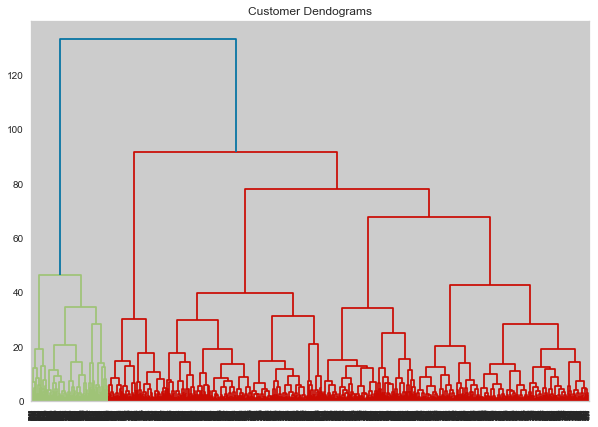

In [188]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(reduced_data, method='ward'))